# DPL Cable Fault EDA

#### muPDNA-esque Outline:

Current State:  Aging cables cause an increasing number of faults

Future State:  Allocated funds are used optimally to decrease the number of faults via replacement

Gap:  Find factors by which we can decrease the number of cable faults (and number of customers affected) as much as possible, given the funding available


Hypothesis that link to the gap:
- Choosing the cables that are most efficient to replace, with respect to the number of customers affected divided by the total cost of replacement, will lease to an optimal decrease in cable outages
- Choosing better service providers (cable replacement contractors) will optimally decrease the number of cable faults
- Increasing funding will optimally decrease the number of cable faults


Thoughts for analyses, across TCMS and non-TCMS data:
- Solely TCMS-based analysis (EDA) of URD outages by filtering for failed devices that are Underground Primary | Then, compare this to the underground outages that I am seeing in the Excel sheet
- Look at whether certain service providers have more faults per cable implanted than other service providers (Also, given the weightage of time, as more time will cause a greater increase in faults)
- Conduct text analysis of the free text columns
- Check the average investment, CMI, and faults present on above ground assets and see if underground cables are underinvested or overinvested in

Project ideas:
- Model that gives, for the following year, the percentage chance of failure for each circuit (or other breakup of cable), the predicted number of customers that would be affected, and other such information
- Give a recommendation to decrease or increase the cable replacement budget
- Give a recommendation of which service provider (cable replacement contractors) to drop, if any

## Installing libraries and extracting Dataset

In [2]:
# Packages
import pandas as pd
import numpy as np
from dateutil.parser import parse
from datetime import datetime
import csv
import matplotlib.pyplot as plt
import math
import matplotlib.ticker
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
#import geopy.distance

# Visuals Setup
import IPython.core.display as di
%matplotlib inline
sns.set_style({'axes.facecolor':'white'})
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
from IPython.display import display,Markdown
from IPython.display import HTML,IFrame

# Toggle Setup
di.display_html('<script>jQuery(function() {if (jQuery("body.notebook_app").length == 0) { jQuery(".input_area").toggle(); jQuery(".prompt").toggle();}});</script>', raw=True)
di.display_html('''<button style="color:"black";right:75%;" onclick="jQuery('.input_area').toggle(); jQuery('.prompt').toggle();">Toggle code</button>''', raw=True)

Toggle code

In [3]:
# Markdown Display
def printmd(string):
    display(Markdown(string))

In [4]:
#Loading in the combine outages dataset
df = pd.read_csv('gs://aes-datahub-0002-curated/Outage_Restoration/Underground_Cable_Datasets/DPL_EDA_Dataset.csv')
df['TIME_OF_FIRST_CALL'] = pd.to_datetime(df['TIME_OF_FIRST_CALL'], infer_datetime_format = True, errors = 'coerce')
df['DATETIMERELEASED'] = pd.to_datetime(df['DATETIMERELEASED'], infer_datetime_format = True, errors = 'coerce')

In [5]:
df = df[(df['TIME_OF_FIRST_CALL'] >= '2007-01-01 00:00:00') & (df['TIME_OF_FIRST_CALL'] <= '2020-01-01 00:00:00')]
#The reason why we are filtering from 2007 is because some of the tables are only imported from 2007 which was originally done for the Outage Restoration project because Clue Codes remained stable from 2007 
#onwards

In [6]:
df['MONTH'] = df.TIME_OF_FIRST_CALL.dt.month
df['YEAR'] = df.TIME_OF_FIRST_CALL.dt.year
df['DAYofMONTH'] = df.TIME_OF_FIRST_CALL.dt.day
df['DAYofYEAR'] = df.TIME_OF_FIRST_CALL.dt.dayofyear

In [27]:
#Setting the two- and three- color palettes for the EDA
p2 = ['#0575ac', '#81cb29']
p3 = ['#0575ac', '#81cb29', '#8e44ad']

## Outages/Day, #Outages, and AvgTTR

In [7]:
df = df[df['TTR'] <= 20160]

In [8]:
df.FAILED_DEVICE.unique()

array(['Underground Primary Cable', 'Underground Service Cable',
       'Underground Secondary Cable'], dtype=object)

[(-50.0, 1440.0)]

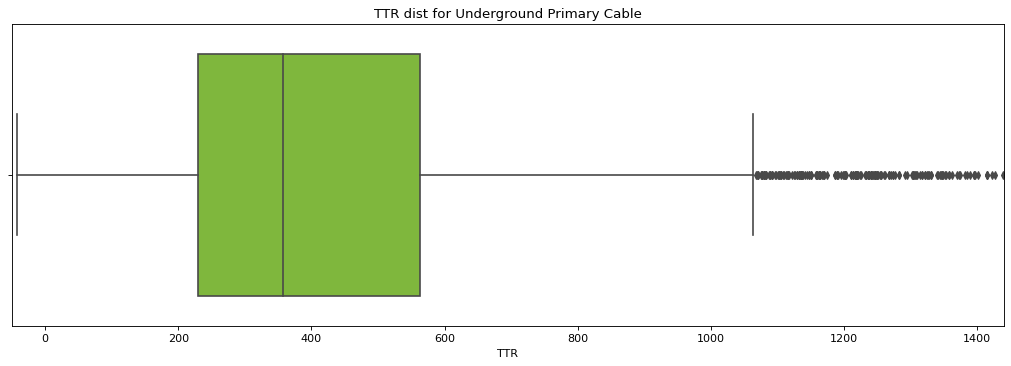

In [9]:
plt.figure(num = None,figsize=(16, 5),dpi=80,facecolor='w',edgecolor='k')
ax = sns.boxplot(df[df.FAILED_DEVICE == 'Underground Primary Cable'].TTR, palette = ['#81cb29'])
ax.set_title('TTR dist for Underground Primary Cable')
ax.set(xlim=(-50, 1440))

[(-50.0, 1440.0)]

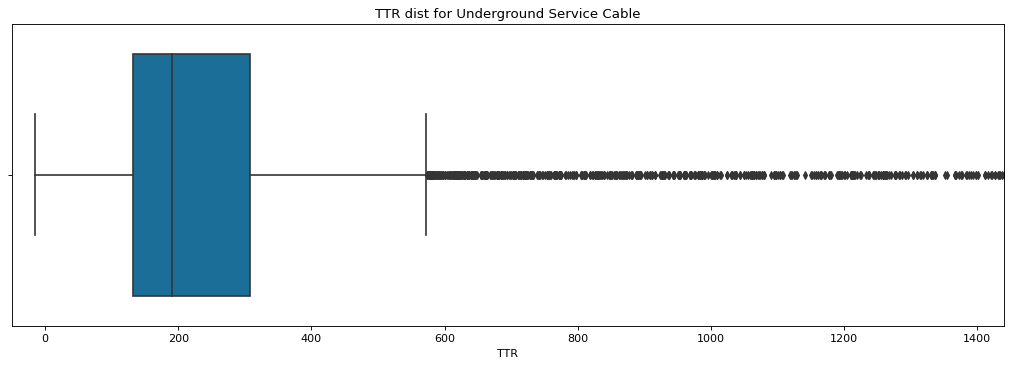

In [10]:
plt.figure(num = None,figsize=(16, 5),dpi=80,facecolor='w',edgecolor='k')
ax = sns.boxplot(df[df.FAILED_DEVICE == 'Underground Service Cable'].TTR, palette = ['#0575ac'])
ax.set_title('TTR dist for Underground Service Cable')
ax.set(xlim=(-50, 1440))

[(-50.0, 1440.0)]

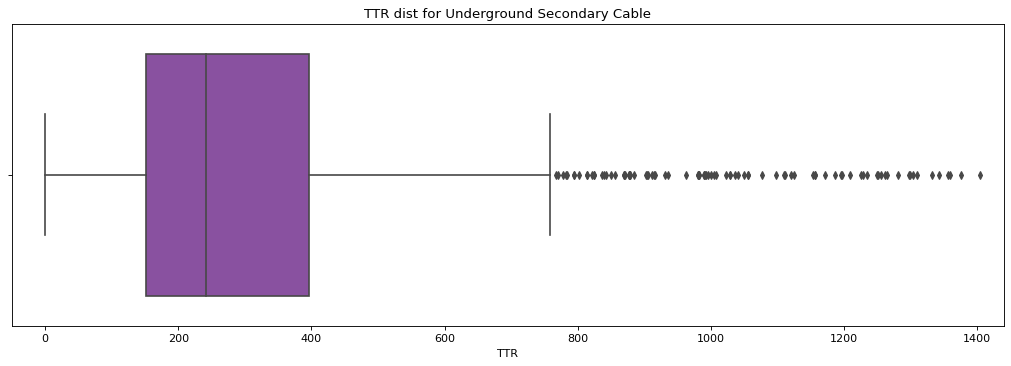

In [11]:
plt.figure(num = None,figsize=(16, 5),dpi=80,facecolor='w',edgecolor='k')
ax = sns.boxplot(df[df.FAILED_DEVICE == 'Underground Secondary Cable'].TTR, palette = ['#8e44ad'])
ax.set_title('TTR dist for Underground Secondary Cable')
ax.set(xlim=(-50, 1440))

In [12]:
avg_df = df
avg_df = avg_df.groupby(['YEAR', 'DAYofYEAR']).size().reset_index(name='Count')
 
######################### Collating in table  ##########################

data = {'Outages/Day':[round(avg_df['Count'].mean(),2)], 
        '#Outages':[df.OUTAGE_ID.nunique()],
        'Average Restoration Time (in Hours)':[round((df['TTR']/60).mean(),2)], 
        'Median Restoration Time (in Hours)':[round((df['TTR']/60).median(),2)]} 
  
# Creates pandas DataFrame. 
df4 = pd.DataFrame(data)#, #index = ['Blue Sky', 'Storm'])
print(df4)
#display(HTML(df.to_html(index=True)))

   Outages/Day  #Outages  Average Restoration Time (in Hours)  Median Restoration Time (in Hours)
0          3.1     13507                                 6.59                                4.12


# Overall Count of TTR

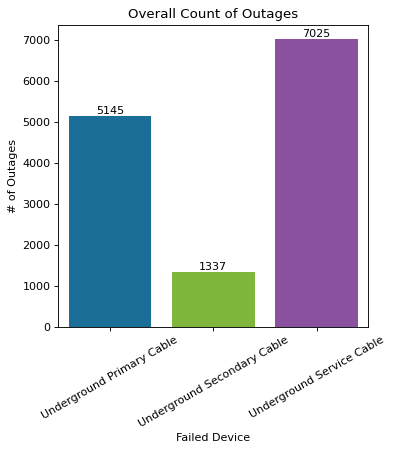

In [13]:
plt.figure(num = None,figsize=(5, 5),dpi=80,facecolor='w',edgecolor='k')

temp_df = df[['FAILED_DEVICE','YEAR','OUTAGE_ID']]
temp_df = df.groupby(['FAILED_DEVICE'],as_index = False).agg({'OUTAGE_ID':'count'})

ax = sns.barplot(x = temp_df['FAILED_DEVICE'],y = temp_df['OUTAGE_ID'],palette = ['#0575ac', '#81cb29', '#8e44ad'])
ax.set(xlabel = 'Failed Device', ylabel = '# of Outages')
ax.set_title('Overall Count of Outages')
plt.xticks(rotation=30)
for p in ax.patches:
    x=p.get_bbox().get_points()[:,0]
    y=p.get_bbox().get_points()[1,1]
    ax.annotate('{:.0f}'.format(y), (x.mean(), y), 
            ha='center', va='bottom') # set the alignment of the text
ax.grid(False)

# Number of Outages Across Time From 2007 Through 2020

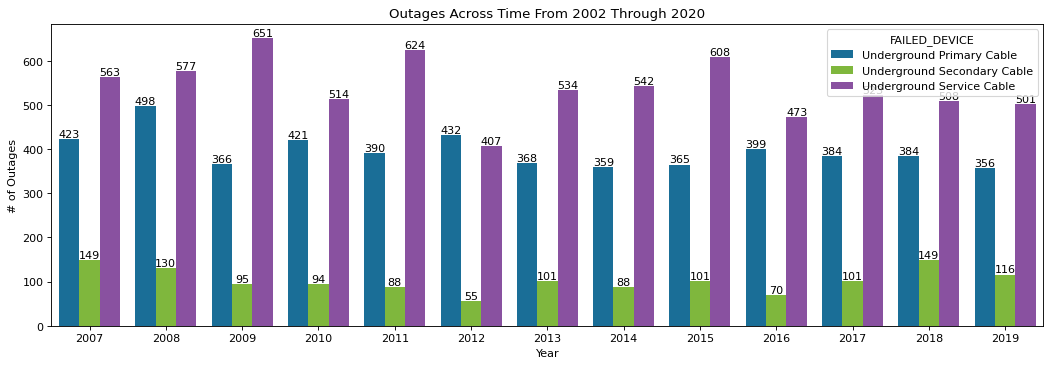

In [14]:
plt.figure(num = None,figsize=(16, 5),dpi=80,facecolor='w',edgecolor='k')

temp_df = df[['FAILED_DEVICE','YEAR','OUTAGE_ID']]
temp_df = temp_df.groupby(['FAILED_DEVICE','YEAR'],as_index = False).agg({'OUTAGE_ID':'count'})

ax = sns.barplot(x = temp_df['YEAR'],y = temp_df['OUTAGE_ID'],hue = temp_df['FAILED_DEVICE'],palette = ['#0575ac', '#81cb29', '#8e44ad'])
ax.set(xlabel = 'Year', ylabel = '# of Outages')
ax.set_title('Outages Across Time From 2002 Through 2020')
for p in ax.patches:
    x=p.get_bbox().get_points()[:,0]
    y=p.get_bbox().get_points()[1,1]
    ax.annotate('{:.0f}'.format(y), (x.mean(), y), 
            ha='center', va='bottom') # set the alignment of the text
ax.grid(False)  

# Avg TTR for Outages Across Time From 2007 Through 2020

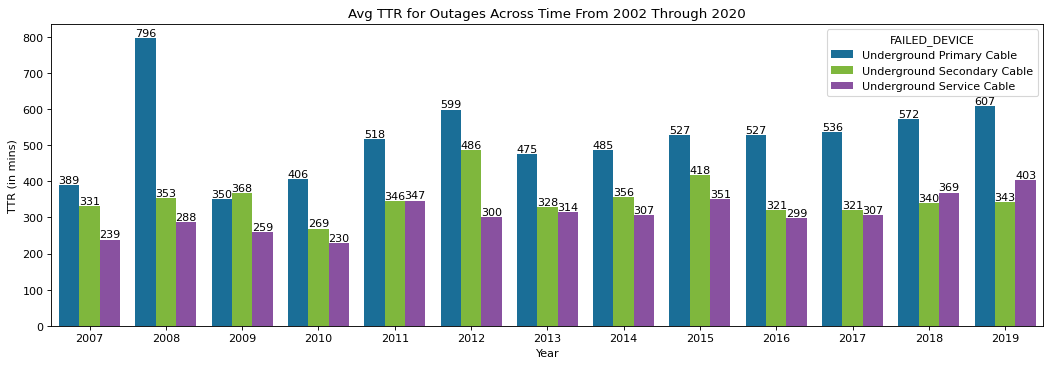

In [15]:
plt.figure(num = None,figsize=(16, 5),dpi=80,facecolor='w',edgecolor='k')

temp_df = df[['FAILED_DEVICE','YEAR','TTR']]
temp_df = temp_df.groupby(['FAILED_DEVICE','YEAR'],as_index = False).agg({'TTR':'mean'})

ax = sns.barplot(x = temp_df['YEAR'],y = temp_df['TTR'],hue = temp_df['FAILED_DEVICE'],palette = ['#0575ac', '#81cb29', '#8e44ad'])
ax.set(xlabel = 'Year', ylabel = 'TTR (in mins)')
ax.set_title('Avg TTR for Outages Across Time From 2002 Through 2020')
for p in ax.patches:
    x=p.get_bbox().get_points()[:,0]
    y=p.get_bbox().get_points()[1,1]
    ax.annotate('{:.0f}'.format(y), (x.mean(), y), 
            ha='center', va='bottom') # set the alignment of the text
ax.grid(False)  

### Checking to see whether there is an increase in the rate of outages on storm days as opposed to blue sky days

In [16]:
temp_df = df[['OUTAGE_ID', 'TIME_OF_FIRST_CALL', 'EVENT']]
perc_storm_days = round(float(temp_df[temp_df['EVENT'] == 'STORM']['TIME_OF_FIRST_CALL'].dt.date.nunique()) / float((pd.to_datetime('2020-01-01') - pd.to_datetime('2007-01-01')).days) * 100, 3)
perc_storm_out = round((len(df[df['EVENT'] == 'STORM'])/len(df) * 100), 3)

In [17]:
print('Storm days account for', 
      str(perc_storm_days) + '%', 
      'of all recorded days from the beginning of 2007 through 2019')
print('Storm cable outages account for', 
      str(perc_storm_out) + '%', 
      'of all recorded cable outages from 2007 through 2019')

Storm days account for 1.896% of all recorded days from the beginning of 2007 through 2019
Storm cable outages account for 2.458% of all recorded cable outages from 2007 through 2019


In [18]:
data = [['Percentage Storm Days', perc_storm_days],
        ['Percentage Storm Outages', perc_storm_out]
       ]

In [19]:
temp_df = pd.DataFrame(data, columns = ['Type', 
                                        'Percent'])

Text(0.5, 1.0, 'Comparison of Percent Storm Days to Percent of Storm Outages (Percent of [Blue Sky + Storm])')

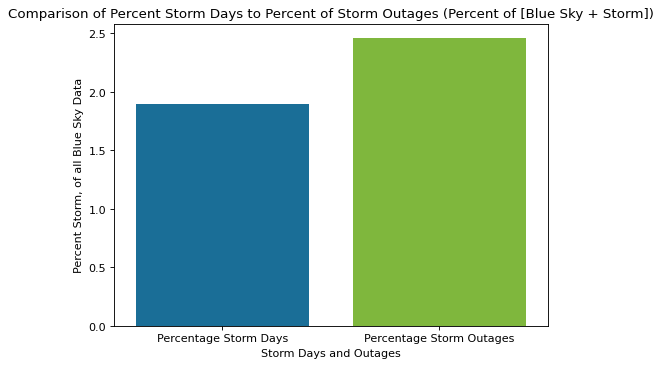

In [20]:
plt.figure(num = None,figsize=(7, 5),dpi=80,facecolor='w',edgecolor='k')

ax = sns.barplot(x = temp_df['Type'],y = temp_df['Percent'],palette = ['#0575ac', '#81cb29'])
ax.set(xlabel = 'Storm Days and Outages', ylabel = 'Percent Storm, of all Blue Sky Data')
ax.set_title('Comparison of Percent Storm Days to Percent of Storm Outages (Percent of [Blue Sky + Storm])')

Storms MAY have a slight increasing affect on cable outages, although there are too few storm days to tell for sure

### Breaking down the type of outage (call type) for each type of cable outage

(array([0, 1, 2, 3, 4, 5, 6]),
 [Text(0, 0, 'ACCOUNT OPEN / RECONNECT'),
  Text(1, 0, 'ALL OUT'),
  Text(2, 0, 'FIRE/EXPLOSION'),
  Text(3, 0, 'FLICKERING LIGHTS'),
  Text(4, 0, 'MISCELLANEOUS ELECTRIC TROUBLE'),
  Text(5, 0, 'NIGHTGUARD OUT'),
  Text(6, 0, 'PARTIAL OUTAGE')])

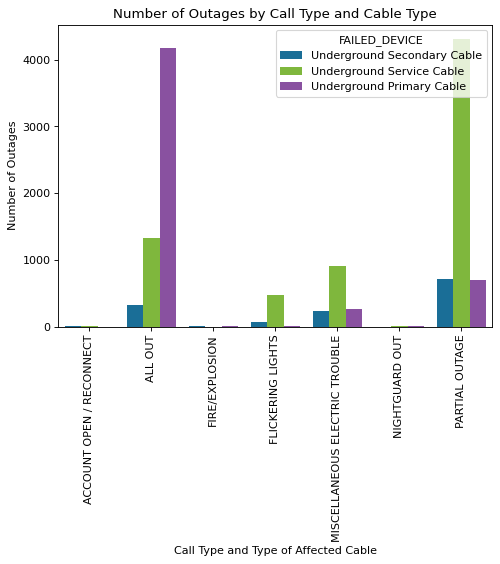

In [21]:
plt.figure(num = None,figsize=(7, 5),dpi=80,facecolor='w',edgecolor='k')

temp_df = df[['OUTAGE_ID', 'FAILED_DEVICE', 'CALL_TYPE']]
temp_df = temp_df.groupby(['CALL_TYPE', 'FAILED_DEVICE'], as_index = False).agg({'OUTAGE_ID': 'count'})

ax = sns.barplot(x = temp_df['CALL_TYPE'],y = temp_df['OUTAGE_ID'],hue = temp_df['FAILED_DEVICE'], palette = ['#0575ac', '#81cb29', '#8e44ad'])
ax.set(xlabel = 'Call Type and Type of Affected Cable', ylabel = 'Number of Outages')
ax.set_title('Number of Outages by Call Type and Cable Type')
plt.xticks(rotation=90)

The Primary Cable Outages tend to cause complete outages while the Service Cable Outages tend to cause partial ones.  Secondary Cable Outages tend to cause a little bit of each type of outage.

In [22]:
df.head()

,OUTAGE_ID,DEVICE_ID,CIRCUIT,DEVICE,TIME_OF_FIRST_CALL,PHASE_A_CUSTS,PHASE_B_CUSTS,PHASE_C_CUSTS,PHASE_T_CUSTS,PHASE_A_CALLS,PHASE_B_CALLS,PHASE_C_CALLS,PHASE_T_CALLS,BRANCHIND,PHASE_A,PHASE_B,PHASE_C,PHASE_T,TOTAL_CUSTS,SAFETY,SORTLEVEL,ALLRESTORED,LFS_CUSTS,MED_CUSTS,EMR_CUSTS,UTL_CUSTS,MAJ_CUSTS,GOV_CUSTS,LRT_CUSTS,STATUS,OUTAGE_NAME,HOLD,WIREDOWN_PTH,WIREDOWN_PTP,TREEONWIRE_PTH,TREEONWIRE_PTP,BROKENPOLE,FIREEXPLOSION,DAMAGEDTRANS,LATITUDE,LONGITUDE,ARC_INDEX,CLOSEST_CREW,PREFERRED_CREW,PRIORITY,CONFIDENCE,REMARKS,CUSTSTILLOUT,DATETIMEADDED,MADESAFE,INTDEV_ID,OVERTIME,ECD,MATERIALHOLD,LASTUPDATE,ECD_OVERRIDE,URD_OUTAGE,SCOUTED,TREE_VERIFIED,TREE_CLEARED,TREE_CLEARED_NO_WORK_NEEDED,MATERIALS_DELIVERED,CALLED_CUSTOMER_OK,CREW_NEEDS_HELP,NONRES_CUSTS,NONRES_CALLS,PUBLIC_SAFETY,HYDRO_VAC_NEEDED,HYDRO_VAC_DISPATCHED,HYDRO_VAC_COMPLETED,FAILED_DEVICE,INTERRUPTING_DEVICE,CAUSEDESCRIPTION,SPOKEN_CAUSE_TEXT,CALL_TYPE,CREWSIZE,DATETIMERELEASED,TTR,PREFERRED_TREE_CREW_FLG,PREFERRED_SCOUT_CREW_FLG,FROMDATE,TODATE,STORMCUSTS,STORM_TYPE,EVENT,MONTH,YEAR,DAYofMONTH,DAYofYEAR
1000,605326,26484.0,GR1204,C7588,2007-03-25 10:26:49,0.0,24.0,0.0,0.0,0.0,4.0,0.0,0.0,2,False,True,False,False,24.0,False,6.0,-1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6,B-C7588,False,False,False,False,False,False,False,False,39.634170,-83.942251,2,677.0,345.0,False,H,BLEW BACK-NEEDS HELP[03251153] PICKED UP 1ST ...,0,25-03-2007 10:29:33,False,1.0,False,25-03-2007 16:00:00,False,02-04-2007 00:44:08,True,False,False,False,False,False,False,False,False,0.0,0.0,False,False,False,False,Underground Primary Cable,Branch Line Fuse or Riser,Equipment Failure,was caused by damage to D P and L equipment,ALL OUT,1.0,2007-03-25 14:30:21,244.0,False,False,NaN,NaN,NaN,NaN,BLUE SKY,3,2007,25,84
1001,598609,5716.0,ME1201,C2005,2007-02-12 00:30:01,46.0,0.0,0.0,0.0,16.0,0.0,0.0,0.0,2,True,False,False,False,46.0,False,3.0,-1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6,B-C2005,False,False,False,False,False,False,False,False,39.850834,-84.389423,2,651.0,651.0,False,H,eta in 10 min[02120136]fault indicators found ...,0,12-02-2007 00:32:21,False,1.0,False,NaN,False,12-02-2007 14:46:25,True,False,False,False,False,False,False,False,False,1.0,0.0,False,False,False,False,Underground Primary Cable,Branch Line Fuse or Riser,Equipment Failure,was caused by damage to D P and L equipment,ALL OUT,4.0,2007-02-12 14:46:21,856.0,False,False,NaN,NaN,NaN,NaN,BLUE SKY,2,2007,12,43
1002,598574,1700.0,RG1210,C2298,2007-02-11 06:52:33,0.0,0.0,38.0,0.0,0.0,0.0,11.0,0.0,2,False,False,True,False,38.0,False,6.0,-1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6,B-C2298,False,False,False,False,False,False,False,False,39.657836,-84.113244,2,339.0,339.0,False,H,picked up 2 transformers--on to the lbc[021108...,0,11-02-2007 06:55:15,False,1.0,False,11-02-2007 11:00:00,False,11-02-2007 09:15:40,True,False,False,False,False,False,False,False,False,2.0,0.0,False,False,False,False,Underground Primary Cable,Branch Line Fuse or Riser,Equipment Failure,was caused by damage to D P and L equipment,ALL OUT,1.0,2007-02-11 09:15:25,143.0,False,False,NaN,NaN,NaN,NaN,BLUE SKY,2,2007,11,42
1012,597365,54544.0,RD1213,A9753,2007-01-30 03:22:13,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,2,False,False,False,True,3.0,False,7.0,-1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6,B-A9753,False,False,False,False,False,False,False,False,39.824167,-84.199135,2,635.0,635.0,False,H,BAD URD CABLE FROM RISER TO 1ST 3-PHASE TRF. N...,0,30-01-2007 03:22:13,False,1.0,False,30-01-2007 07:00:00,False,30-01-2007 06:48:53,True,False,False,False,False,False,False,False,False,0.0,0.0,False,False,False,False,Underground Primary Cable,Branch Line Fuse or Riser,Equipment Failure,was caused by damage to D P and L equipment,ALL OUT,2.0,2007-01-30 06:48:49,207.0,False,False,NaN,NaN,NaN,NaN,BLUE SKY,1,2007,30,30
1013,599977,23114.0,JD1211,C2215,2007-02-14 07:03:27,0.0,0.0,6.0,0.0,0.0,0.0,6.0,0.0,2,False,False,True,False,6.0,False,20.0,-1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6,B-C2215,True,False,False,False,False,False,False,False,39.610028,

In [25]:
temp_df = df[['OUTAGE_ID', 'CREWSIZE', 'FAILED_DEVICE']]

In [ ]:
temp_df.groupby(['FAILED_DEVICE'])

Text(0.5, 1.0, 'TTR dist for Underground Primary Cable')

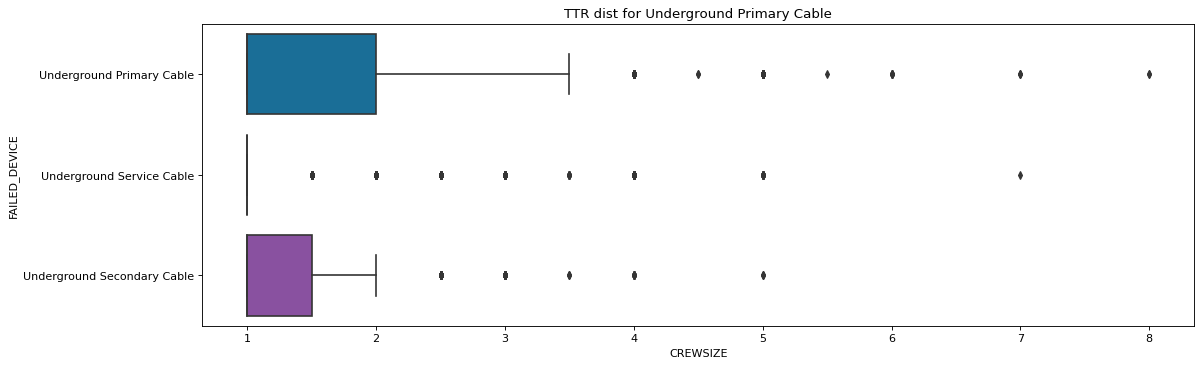

In [34]:
plt.figure(num = None,figsize=(16, 5),dpi=80,facecolor='w',edgecolor='k')
ax = sns.boxplot(y = temp_df['FAILED_DEVICE'], x = temp_df['CREWSIZE'], palette = p3)
ax.set_title('TTR dist for Underground Primary Cable')

In [ ]:
#Just digging a bit deeper into the numbers to get some concrete understanding of the crew size that is necessary

In [23]:
temp_df = df[['OUTAGE_ID', 'TOTAL_CUSTS', 'FAILED_DEVICE']]

# Distribution of Avg TTR vs Categorical variables

## As expected, tree on wire and wire down clue codes are uncommon for underground cable fault occurrence

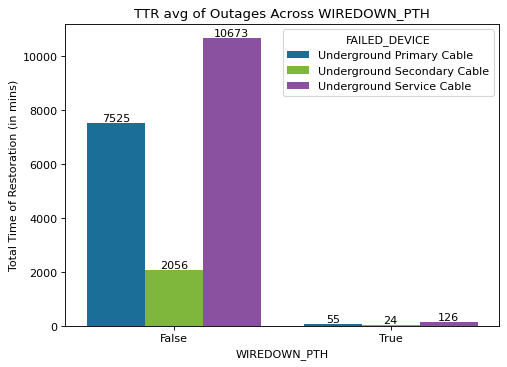

In [74]:
plt.figure(num = None,figsize=(7, 5),dpi=80,facecolor='w',edgecolor='k')

temp_df = df[['FAILED_DEVICE','WIREDOWN_PTH','TTR']]
temp_df = temp_df.groupby(['FAILED_DEVICE','WIREDOWN_PTH'],as_index = False).agg({'TTR':'count'})

ax = sns.barplot(x = temp_df['WIREDOWN_PTH'],y = temp_df['TTR'],hue = temp_df['FAILED_DEVICE'],palette = ['#0575ac', '#81cb29', '#8e44ad'])
ax.set(xlabel = 'WIREDOWN_PTH', ylabel = 'Total Time of Restoration (in mins)')
ax.set_title('TTR avg of Outages Across WIREDOWN_PTH')
for p in ax.patches:
    x=p.get_bbox().get_points()[:,0]
    y=p.get_bbox().get_points()[1,1]
    ax.annotate('{:.0f}'.format(y), (x.mean(), y), 
            ha='center', va='bottom') # set the alignment of the text
ax.grid(False)  

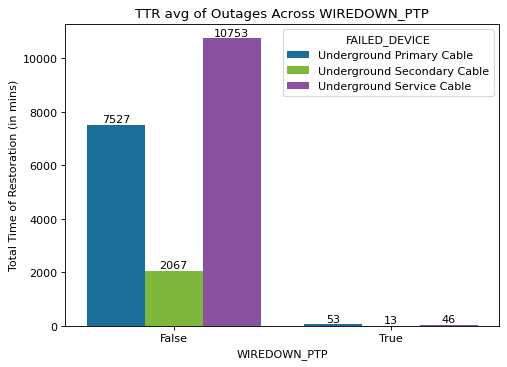

In [75]:
plt.figure(num = None,figsize=(7, 5),dpi=80,facecolor='w',edgecolor='k')

temp_df = df[['FAILED_DEVICE','WIREDOWN_PTP','TTR']]
temp_df = temp_df.groupby(['FAILED_DEVICE','WIREDOWN_PTP'],as_index = False).agg({'TTR':'count'})

ax = sns.barplot(x = temp_df['WIREDOWN_PTP'],y = temp_df['TTR'],hue = temp_df['FAILED_DEVICE'],palette = ['#0575ac', '#81cb29', '#8e44ad'])
ax.set(xlabel = 'WIREDOWN_PTP', ylabel = 'Total Time of Restoration (in mins)')
ax.set_title('TTR avg of Outages Across WIREDOWN_PTP')
for p in ax.patches:
    x=p.get_bbox().get_points()[:,0]
    y=p.get_bbox().get_points()[1,1]
    ax.annotate('{:.0f}'.format(y), (x.mean(), y), 
            ha='center', va='bottom') # set the alignment of the text
ax.grid(False)  

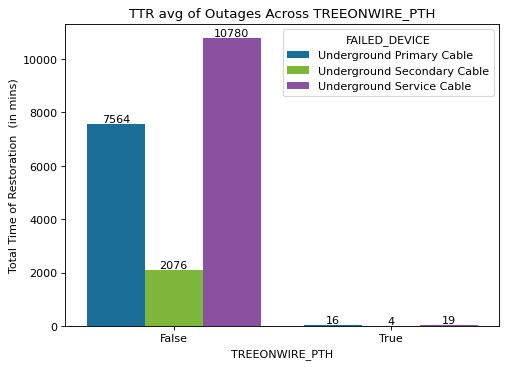

In [76]:
plt.figure(num = None,figsize=(7, 5),dpi=80,facecolor='w',edgecolor='k')

temp_df = df[['FAILED_DEVICE','TREEONWIRE_PTH','TTR']]
temp_df = temp_df.groupby(['FAILED_DEVICE','TREEONWIRE_PTH'],as_index = False).agg({'TTR':'count'})

ax = sns.barplot(x = temp_df['TREEONWIRE_PTH'],y = temp_df['TTR'],hue = temp_df['FAILED_DEVICE'],palette =['#0575ac', '#81cb29', '#8e44ad'])
ax.set(xlabel = 'TREEONWIRE_PTH', ylabel = 'Total Time of Restoration  (in mins)')
ax.set_title('TTR avg of Outages Across TREEONWIRE_PTH')
for p in ax.patches:
    x=p.get_bbox().get_points()[:,0]
    y=p.get_bbox().get_points()[1,1]
    ax.annotate('{:.0f}'.format(y), (x.mean(), y), 
            ha='center', va='bottom') # set the alignment of the text
ax.grid(False)  

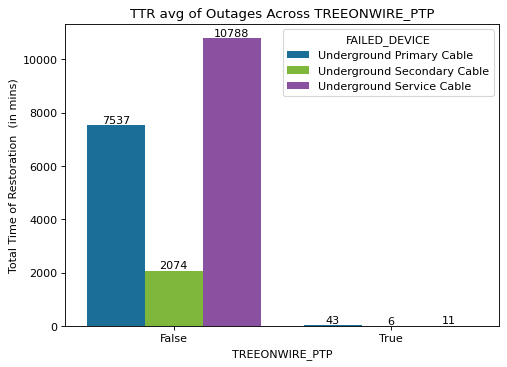

In [77]:
plt.figure(num = None,figsize=(7, 5),dpi=80,facecolor='w',edgecolor='k')

temp_df = df[['FAILED_DEVICE','TREEONWIRE_PTP','TTR']]
temp_df = temp_df.groupby(['FAILED_DEVICE','TREEONWIRE_PTP'],as_index = False).agg({'TTR':'count'})

ax = sns.barplot(x = temp_df['TREEONWIRE_PTP'],y = temp_df['TTR'],hue = temp_df['FAILED_DEVICE'],palette = ['#0575ac', '#81cb29', '#8e44ad'])
ax.set(xlabel = 'TREEONWIRE_PTP', ylabel = 'Total Time of Restoration  (in mins)' )
ax.set_title('TTR avg of Outages Across TREEONWIRE_PTP')
for p in ax.patches:
    x=p.get_bbox().get_points()[:,0]
    y=p.get_bbox().get_points()[1,1]
    ax.annotate('{:.0f}'.format(y), (x.mean(), y), 
            ha='center', va='bottom') # set the alignment of the text
ax.grid(False)  

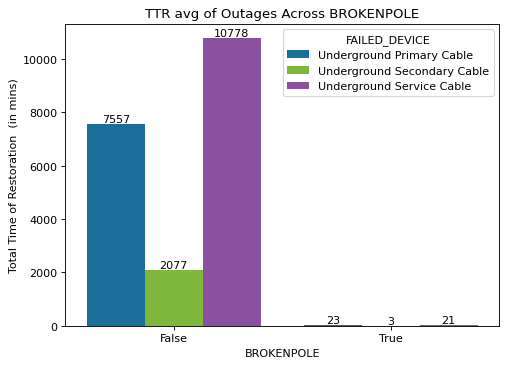

In [78]:
plt.figure(num = None,figsize=(7, 5),dpi=80,facecolor='w',edgecolor='k')

temp_df = df[['FAILED_DEVICE','BROKENPOLE','TTR']]
temp_df = temp_df.groupby(['FAILED_DEVICE','BROKENPOLE'],as_index = False).agg({'TTR':'count'})

ax = sns.barplot(x = temp_df['BROKENPOLE'],y = temp_df['TTR'],hue = temp_df['FAILED_DEVICE'],palette = ['#0575ac', '#81cb29', '#8e44ad'])
ax.set(xlabel = 'BROKENPOLE', ylabel = 'Total Time of Restoration  (in mins)')
ax.set_title('TTR avg of Outages Across BROKENPOLE')
for p in ax.patches:
    x=p.get_bbox().get_points()[:,0]
    y=p.get_bbox().get_points()[1,1]
    ax.annotate('{:.0f}'.format(y), (x.mean(), y), 
            ha='center', va='bottom') # set the alignment of the text
ax.grid(False)  

## Outages due to FIREEXPLOSION is lower than Outages caused due to other reasons

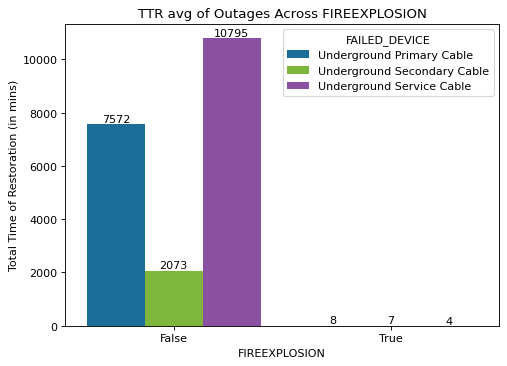

In [79]:
plt.figure(num = None,figsize=(7, 5),dpi=80,facecolor='w',edgecolor='k')

temp_df = df[['FAILED_DEVICE','FIREEXPLOSION','TTR']]
temp_df = temp_df.groupby(['FAILED_DEVICE','FIREEXPLOSION'],as_index = False).agg({'TTR':'count'})

ax = sns.barplot(x = temp_df['FIREEXPLOSION'],y = temp_df['TTR'],hue = temp_df['FAILED_DEVICE'],palette = ['#0575ac', '#81cb29', '#8e44ad'])
ax.set(xlabel = 'FIREEXPLOSION', ylabel = 'Total Time of Restoration (in mins)')
ax.set_title('TTR avg of Outages Across FIREEXPLOSION')
for p in ax.patches:
    x=p.get_bbox().get_points()[:,0]
    y=p.get_bbox().get_points()[1,1]
    ax.annotate('{:.0f}'.format(y), (x.mean(), y), 
            ha='center', va='bottom') # set the alignment of the text
ax.grid(False)  

## Outages due to DAMAGEDTRANS is higher for Storm Outages

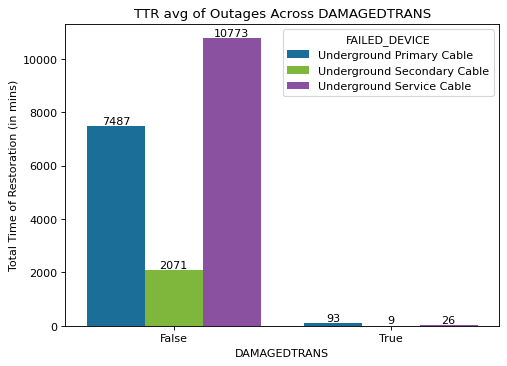

In [80]:
plt.figure(num = None,figsize=(7, 5),dpi=80,facecolor='w',edgecolor='k')

temp_df = df[['FAILED_DEVICE','DAMAGEDTRANS','TTR']]
temp_df = temp_df.groupby(['FAILED_DEVICE','DAMAGEDTRANS'],as_index = False).agg({'TTR':'count'})

ax = sns.barplot(x = temp_df['DAMAGEDTRANS'],y = temp_df['TTR'],hue = temp_df['FAILED_DEVICE'],palette = ['#0575ac', '#81cb29', '#8e44ad'])
ax.set(xlabel = 'DAMAGEDTRANS', ylabel = 'Total Time of Restoration (in mins)')
ax.set_title('TTR avg of Outages Across DAMAGEDTRANS')
for p in ax.patches:
    x=p.get_bbox().get_points()[:,0]
    y=p.get_bbox().get_points()[1,1]
    ax.annotate('{:.0f}'.format(y), (x.mean(), y), 
            ha='center', va='bottom') # set the alignment of the text
ax.grid(False)  

### Plotting impact of different clue codes

In [132]:
'''
temp_df = pd.DataFrame()
temp_df['CLUE'] = ['WIREDOWN_PTH', 'WIREDOWN_PTP','TREEONWIRE_PTH','TREEONWIRE_PTP','BROKENPOLE','FIREEXPLOSION', 'DAMAGEDTRANS',
                   'WIREDOWN_PTH', 'WIREDOWN_PTP','TREEONWIRE_PTH','TREEONWIRE_PTP','BROKENPOLE','FIREEXPLOSION', 'DAMAGEDTRANS']
temp_df['EVENT'] = ['BLUE SKY','BLUE SKY','BLUE SKY','BLUE SKY','BLUE SKY','BLUE SKY','BLUE SKY','STORM','STORM','STORM','STORM','STORM','STORM','STORM']
mean_ttr = []
count = []
for i in range(len(temp_df[temp_df['EVENT'] == 'BLUE SKY'])):
    x = df[(df.EVENT == 'BLUE SKY') & (df[temp_df.CLUE[i]] == True)].TTR.mean()
    mean_ttr.append(x)
    x = df[(df.EVENT == 'BLUE SKY') & (df[temp_df.CLUE[i]] == True)].TTR.count()
    count.append(x)
    
for i in range(len(temp_df[temp_df['EVENT'] == 'STORM'])):
    x = df[(df.EVENT == 'STORM') & (df[temp_df.CLUE[i]] == True)].TTR.mean()
    mean_ttr.append(x)
    x = df[(df.EVENT == 'STORM') & (df[temp_df.CLUE[i]] == True)].TTR.count()
    count.append(x)
    
temp_df['Mean_ttr'] = mean_ttr
temp_df['#Outages'] = count
'''

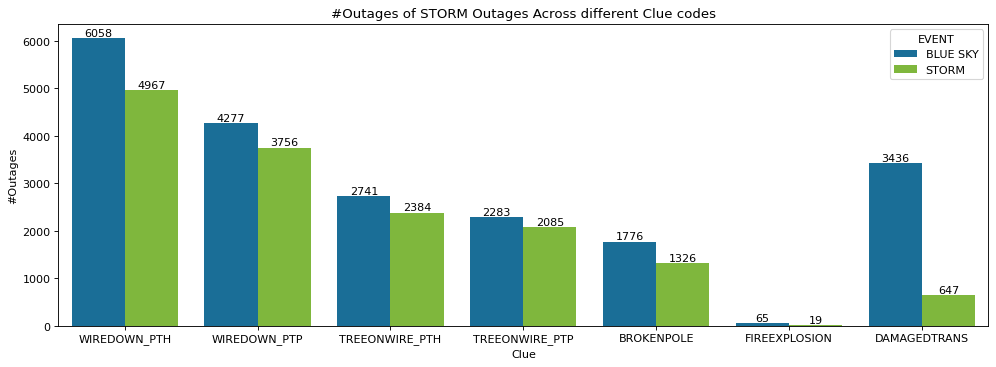

In [133]:
'''
plt.figure(num = None,figsize=(15, 5),dpi=80,facecolor='w',edgecolor='k')
ax = sns.barplot(x = temp_df['CLUE'],y = temp_df['#Outages'],hue = temp_df['EVENT'],palette = ['#0575ac', '#81cb29'])
ax.set(xlabel = 'Clue', ylabel = '#Outages')
ax.set_title('#Outages of STORM Outages Across different Clue codes')
for p in ax.patches:
    x=p.get_bbox().get_points()[:,0]
    y=p.get_bbox().get_points()[1,1]
    ax.annotate('{:.0f}'.format(y), (x.mean(), y), 
            ha='center', va='bottom') # set the alignment of the text
ax.grid(False)
'''

In [81]:
df.head(1)

,OUTAGE_ID,DEVICE_ID,CIRCUIT,DEVICE,TIME_OF_FIRST_CALL,PHASE_A_CUSTS,PHASE_B_CUSTS,PHASE_C_CUSTS,PHASE_T_CUSTS,PHASE_A_CALLS,PHASE_B_CALLS,PHASE_C_CALLS,PHASE_T_CALLS,BRANCHIND,PHASE_A,PHASE_B,PHASE_C,PHASE_T,TOTAL_CUSTS,SAFETY,SORTLEVEL,ALLRESTORED,LFS_CUSTS,MED_CUSTS,EMR_CUSTS,UTL_CUSTS,MAJ_CUSTS,GOV_CUSTS,LRT_CUSTS,STATUS,OUTAGE_NAME,HOLD,WIREDOWN_PTH,WIREDOWN_PTP,TREEONWIRE_PTH,TREEONWIRE_PTP,BROKENPOLE,FIREEXPLOSION,DAMAGEDTRANS,LATITUDE,LONGITUDE,ARC_INDEX,CLOSEST_CREW,PREFERRED_CREW,PRIORITY,CONFIDENCE,REMARKS,CUSTSTILLOUT,DATETIMEADDED,MADESAFE,INTDEV_ID,OVERTIME,ECD,MATERIALHOLD,LASTUPDATE,ECD_OVERRIDE,URD_OUTAGE,SCOUTED,TREE_VERIFIED,TREE_CLEARED,TREE_CLEARED_NO_WORK_NEEDED,MATERIALS_DELIVERED,CALLED_CUSTOMER_OK,CREW_NEEDS_HELP,NONRES_CUSTS,NONRES_CALLS,PUBLIC_SAFETY,HYDRO_VAC_NEEDED,HYDRO_VAC_DISPATCHED,HYDRO_VAC_COMPLETED,FAILED_DEVICE,INTERRUPTING_DEVICE,CAUSEDESCRIPTION,SPOKEN_CAUSE_TEXT,CALL_TYPE,CREWSIZE,DATETIMERELEASED,TTR,PREFERRED_TREE_CREW_FLG,PREFERRED_SCOUT_CREW_FLG,FROMDATE,TODATE,STORMCUSTS,STORM_TYPE,EVENT,MONTH,YEAR,DAYofMONTH,DAYofYEAR
0,228940,26567.0,HF1205,C8111,2002-02-20 21:15:12,5.0,9.0,18.0,0.0,1.0,0.0,0.0,0.0,1,True,False,False,False,1.0,False,6.0,-1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6,I-C8111,False,False,False,False,False,False,False,False,39.535121,-83.848747,2,NaN,708.0,False,H,BAD PIECE OF URD PRIMARY TO HOUSE-WILL NEED 1 ...,0,20-02-2002 21:15:20,False,1.0,False,NaN,False,NaN,False,False,False,False,False,False,False,False,False,0.0,0.0,False,False,False,False,Underground Primary Cable,Branch Line Fuse or Riser,Equipment Failure,was caused by damage to D P and L equipment,ALL OUT,2.0,2002-02-21 03:35:58,381.0,False,False,NaN,NaN,NaN,NaN,BLUE SKY,2,2002,20,51


In [82]:
df.SAFETY

0        False
1        False
2        False
3        False
4        False
         ...  
20454     True
20455    False
20456    False
20457    False
20458    False
Name: SAFETY, Length: 20459, dtype: bool

## Avg TTR across SAFETY 

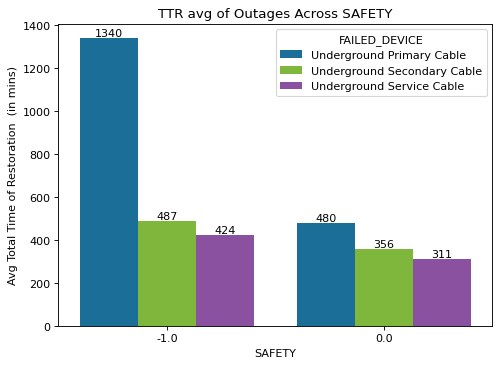

In [26]:
plt.figure(num = None,figsize=(7, 5),dpi=80,facecolor='w',edgecolor='k')

temp_df = df[['FAILED_DEVICE','SAFETY','TTR']]
temp_df = temp_df.groupby(['FAILED_DEVICE','SAFETY'],as_index = False).agg({'TTR':'mean'})

ax = sns.barplot(x = temp_df['SAFETY'],y = temp_df['TTR'],hue = temp_df['FAILED_DEVICE'],palette = ['#0575ac', '#81cb29', '#8e44ad'])
ax.set(xlabel = 'SAFETY', ylabel = 'Avg Total Time of Restoration  (in mins)')
ax.set_title('TTR avg of Outages Across SAFETY')
for p in ax.patches:
    x=p.get_bbox().get_points()[:,0]
    y=p.get_bbox().get_points()[1,1]
    ax.annotate('{:.0f}'.format(y), (x.mean(), y), 
            ha='center', va='bottom') # set the alignment of the text
ax.grid(False)  

## Avg TTR across SORTLEVEL 

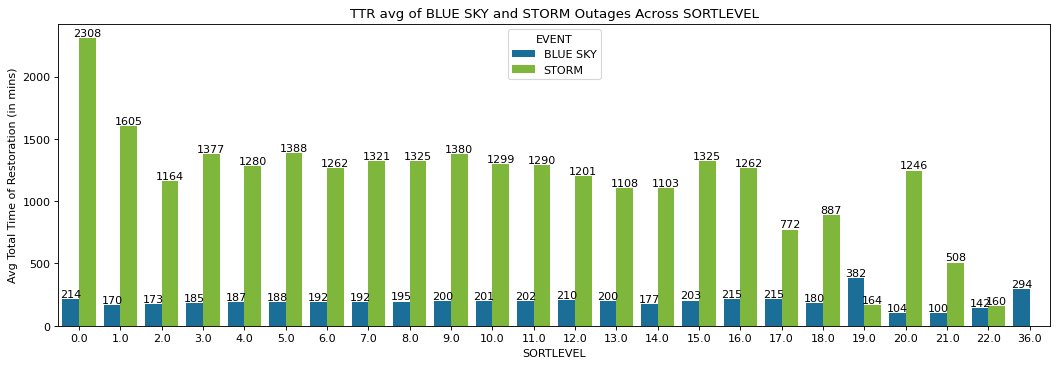

In [138]:
plt.figure(num = None,figsize=(16, 5),dpi=80,facecolor='w',edgecolor='k')

temp_df = df[['EVENT','SORTLEVEL','TTR']]
temp_df = temp_df.groupby(['EVENT','SORTLEVEL'],as_index = False).agg({'TTR':'mean'})

ax = sns.barplot(x = temp_df['SORTLEVEL'],y = temp_df['TTR'],hue = temp_df['EVENT'],palette = ['#0575ac', '#81cb29'])
ax.set(xlabel = 'SORTLEVEL', ylabel = 'Avg Total Time of Restoration (in mins)')
ax.set_title('TTR avg of BLUE SKY and STORM Outages Across SORTLEVEL')
for p in ax.patches:
    x=p.get_bbox().get_points()[:,0]
    y=p.get_bbox().get_points()[1,1]
    ax.annotate('{:.0f}'.format(y), (x.mean(), y), 
            ha='center', va='bottom') # set the alignment of the text
ax.grid(False)  

## Avg TTR across PRIORITY 

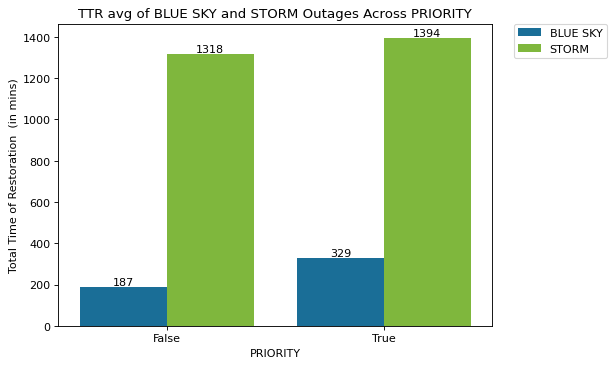

In [139]:
plt.figure(num = None,figsize=(7, 5),dpi=80,facecolor='w',edgecolor='k')

temp_df = df[['EVENT','PRIORITY','TTR']]
temp_df = temp_df.groupby(['EVENT','PRIORITY'],as_index = False).agg({'TTR':'mean'})

ax = sns.barplot(x = temp_df['PRIORITY'],y = temp_df['TTR'],hue = temp_df['EVENT'],palette = ['#0575ac', '#81cb29'])
ax.set(xlabel = 'PRIORITY', ylabel = 'Total Time of Restoration  (in mins)')
ax.set_title('TTR avg of BLUE SKY and STORM Outages Across PRIORITY')
for p in ax.patches:
    x=p.get_bbox().get_points()[:,0]
    y=p.get_bbox().get_points()[1,1]
    ax.annotate('{:.0f}'.format(y), (x.mean(), y), 
            ha='center', va='bottom') # set the alignment of the text
ax.grid(False)  
# Put the legend out of the figure
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

## Avg TTR across CONFIDENCE 

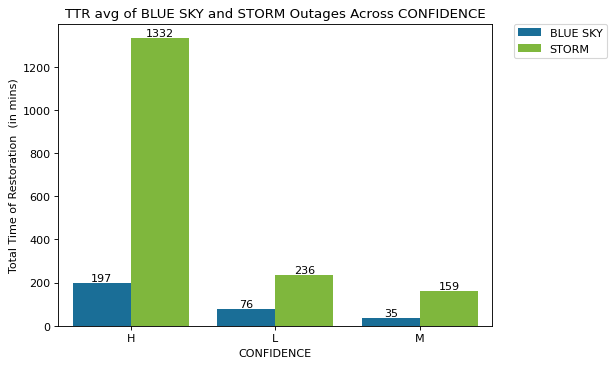

In [140]:
plt.figure(num = None,figsize=(7, 5),dpi=80,facecolor='w',edgecolor='k')

temp_df = df[['EVENT','CONFIDENCE','TTR']]
temp_df = temp_df.groupby(['EVENT','CONFIDENCE'],as_index = False).agg({'TTR':'mean'})

ax = sns.barplot(x = temp_df['CONFIDENCE'],y = temp_df['TTR'],hue = temp_df['EVENT'],palette = ['#0575ac', '#81cb29'])
ax.set(xlabel = 'CONFIDENCE', ylabel = 'Total Time of Restoration  (in mins)')
ax.set_title('TTR avg of BLUE SKY and STORM Outages Across CONFIDENCE')
for p in ax.patches:
    x=p.get_bbox().get_points()[:,0]
    y=p.get_bbox().get_points()[1,1]
    ax.annotate('{:.0f}'.format(y), (x.mean(), y), 
            ha='center', va='bottom') # set the alignment of the text
ax.grid(False)  
# Put the legend out of the figure
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

## Avg TTR across MADESAFE 


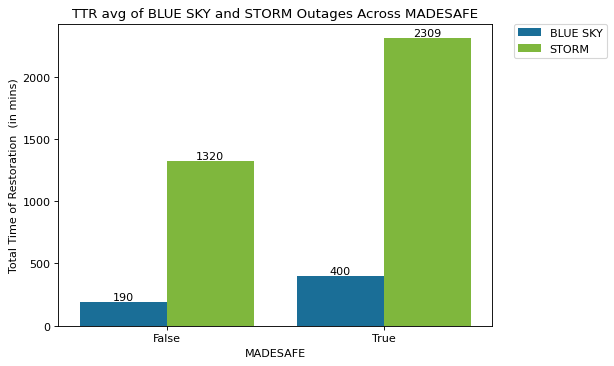

In [141]:
plt.figure(num = None,figsize=(7, 5),dpi=80,facecolor='w',edgecolor='k')

temp_df = df[['EVENT','MADESAFE','TTR']]
temp_df = temp_df.groupby(['EVENT','MADESAFE'],as_index = False).agg({'TTR':'mean'})

ax = sns.barplot(x = temp_df['MADESAFE'],y = temp_df['TTR'],hue = temp_df['EVENT'],palette = ['#0575ac', '#81cb29'])
ax.set(xlabel = 'MADESAFE', ylabel = 'Total Time of Restoration  (in mins)')
ax.set_title('TTR avg of BLUE SKY and STORM Outages Across MADESAFE')
for p in ax.patches:
    x=p.get_bbox().get_points()[:,0]
    y=p.get_bbox().get_points()[1,1]
    ax.annotate('{:.0f}'.format(y), (x.mean(), y), 
            ha='center', va='bottom') # set the alignment of the text
ax.grid(False)  
# Put the legend out of the figure
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

## Avg TTR across MATERIALHOLD 

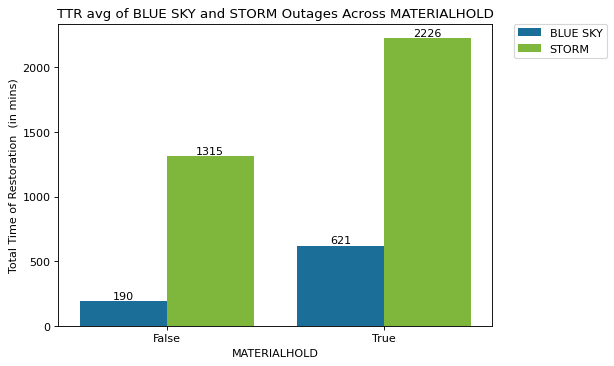

In [142]:
plt.figure(num = None,figsize=(7, 5),dpi=80,facecolor='w',edgecolor='k')

temp_df = df[['EVENT','MATERIALHOLD','TTR']]
temp_df = temp_df.groupby(['EVENT','MATERIALHOLD'],as_index = False).agg({'TTR':'mean'})

ax = sns.barplot(x = temp_df['MATERIALHOLD'],y = temp_df['TTR'],hue = temp_df['EVENT'],palette = ['#0575ac', '#81cb29'])
ax.set(xlabel = 'MATERIALHOLD', ylabel = 'Total Time of Restoration  (in mins)')
ax.set_title('TTR avg of BLUE SKY and STORM Outages Across MATERIALHOLD')
for p in ax.patches:
    x=p.get_bbox().get_points()[:,0]
    y=p.get_bbox().get_points()[1,1]
    ax.annotate('{:.0f}'.format(y), (x.mean(), y), 
            ha='center', va='bottom') # set the alignment of the text
ax.grid(False)  
# Put the legend out of the figure
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

## Avg TTR across URD_OUTAGE 

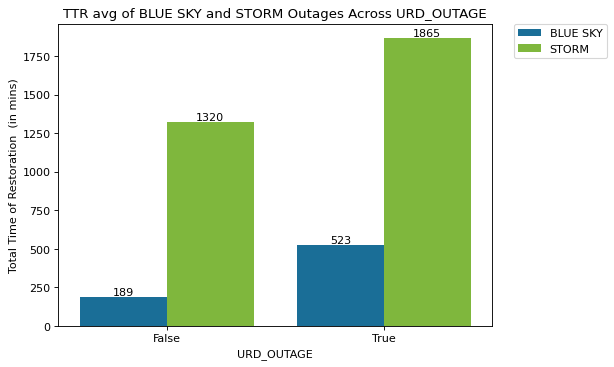

In [143]:
plt.figure(num = None,figsize=(7, 5),dpi=80,facecolor='w',edgecolor='k')

temp_df = df[['EVENT','URD_OUTAGE','TTR']]
temp_df = temp_df.groupby(['EVENT','URD_OUTAGE'],as_index = False).agg({'TTR':'mean'})

ax = sns.barplot(x = temp_df['URD_OUTAGE'],y = temp_df['TTR'],hue = temp_df['EVENT'],palette = ['#0575ac', '#81cb29'])
ax.set(xlabel = 'URD_OUTAGE', ylabel = 'Total Time of Restoration  (in mins)')
ax.set_title('TTR avg of BLUE SKY and STORM Outages Across URD_OUTAGE')
for p in ax.patches:
    x=p.get_bbox().get_points()[:,0]
    y=p.get_bbox().get_points()[1,1]
    ax.annotate('{:.0f}'.format(y), (x.mean(), y), 
            ha='center', va='bottom') # set the alignment of the text
ax.grid(False)  
# Put the legend out of the figure
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

## Avg TTR across SCOUTED 

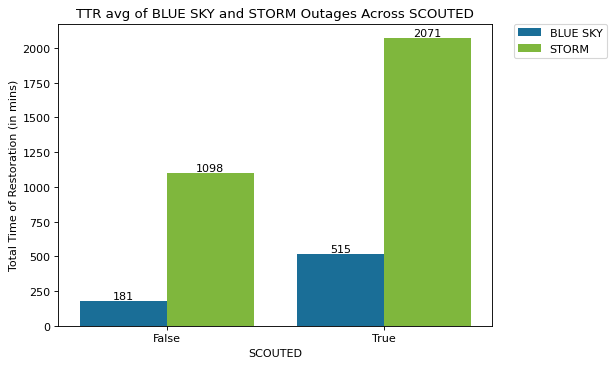

In [144]:
plt.figure(num = None,figsize=(7, 5),dpi=80,facecolor='w',edgecolor='k')

temp_df = df[['EVENT','SCOUTED','TTR']]
temp_df = temp_df.groupby(['EVENT','SCOUTED'],as_index = False).agg({'TTR':'mean'})

ax = sns.barplot(x = temp_df['SCOUTED'],y = temp_df['TTR'],hue = temp_df['EVENT'],palette = ['#0575ac', '#81cb29'])
ax.set(xlabel = 'SCOUTED', ylabel = 'Total Time of Restoration (in mins)')
ax.set_title('TTR avg of BLUE SKY and STORM Outages Across SCOUTED')
for p in ax.patches:
    x=p.get_bbox().get_points()[:,0]
    y=p.get_bbox().get_points()[1,1]
    ax.annotate('{:.0f}'.format(y), (x.mean(), y), 
            ha='center', va='bottom') # set the alignment of the text
ax.grid(False)  
# Put the legend out of the figure
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

## Avg TTR across TREE_VERIFIED 

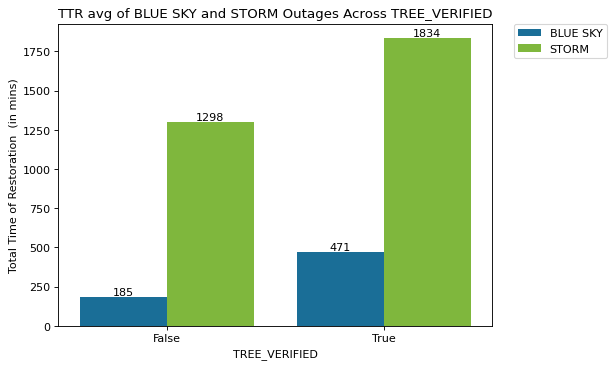

In [145]:
plt.figure(num = None,figsize=(7, 5),dpi=80,facecolor='w',edgecolor='k')

temp_df = df[['EVENT','TREE_VERIFIED','TTR']]
temp_df = temp_df.groupby(['EVENT','TREE_VERIFIED'],as_index = False).agg({'TTR':'mean'})

ax = sns.barplot(x = temp_df['TREE_VERIFIED'],y = temp_df['TTR'],hue = temp_df['EVENT'],palette = ['#0575ac', '#81cb29'])
ax.set(xlabel = 'TREE_VERIFIED', ylabel = 'Total Time of Restoration  (in mins)')
ax.set_title('TTR avg of BLUE SKY and STORM Outages Across TREE_VERIFIED')
for p in ax.patches:
    x=p.get_bbox().get_points()[:,0]
    y=p.get_bbox().get_points()[1,1]
    ax.annotate('{:.0f}'.format(y), (x.mean(), y), 
            ha='center', va='bottom') # set the alignment of the text
ax.grid(False)  
# Put the legend out of the figure
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

## Avg TTR across TREE_CLEARED 

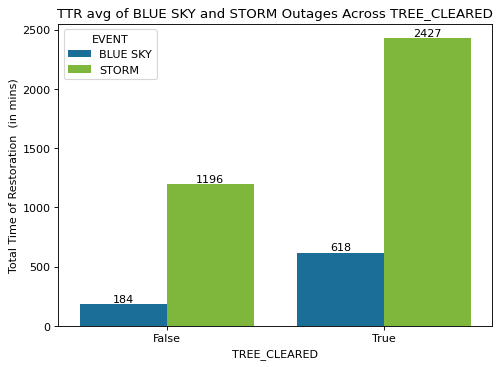

In [146]:
plt.figure(num = None,figsize=(7, 5),dpi=80,facecolor='w',edgecolor='k')

temp_df = df[['EVENT','TREE_CLEARED','TTR']]
temp_df = temp_df.groupby(['EVENT','TREE_CLEARED'],as_index = False).agg({'TTR':'mean'})

ax = sns.barplot(x = temp_df['TREE_CLEARED'],y = temp_df['TTR'],hue = temp_df['EVENT'],palette = ['#0575ac', '#81cb29'])
ax.set(xlabel = 'TREE_CLEARED', ylabel = 'Total Time of Restoration  (in mins)')
ax.set_title('TTR avg of BLUE SKY and STORM Outages Across TREE_CLEARED')
for p in ax.patches:
    x=p.get_bbox().get_points()[:,0]
    y=p.get_bbox().get_points()[1,1]
    ax.annotate('{:.0f}'.format(y), (x.mean(), y), 
            ha='center', va='bottom') # set the alignment of the text
ax.grid(False)  

## Avg TTR across TREE_CLEARED_NO_WORK_NEEDED 

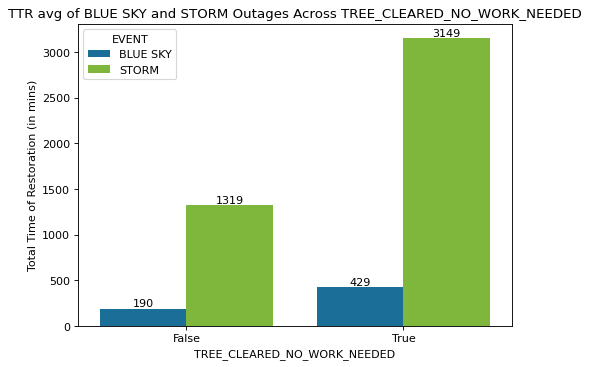

In [147]:
plt.figure(num = None,figsize=(7, 5),dpi=80,facecolor='w',edgecolor='k')

temp_df = df[['EVENT','TREE_CLEARED_NO_WORK_NEEDED','TTR']]
temp_df = temp_df.groupby(['EVENT','TREE_CLEARED_NO_WORK_NEEDED'],as_index = False).agg({'TTR':'mean'})

ax = sns.barplot(x = temp_df['TREE_CLEARED_NO_WORK_NEEDED'],y = temp_df['TTR'],hue = temp_df['EVENT'],palette = ['#0575ac', '#81cb29'])
ax.set(xlabel = 'TREE_CLEARED_NO_WORK_NEEDED', ylabel = 'Total Time of Restoration (in mins)')
ax.set_title('TTR avg of BLUE SKY and STORM Outages Across TREE_CLEARED_NO_WORK_NEEDED')
for p in ax.patches:
    x=p.get_bbox().get_points()[:,0]
    y=p.get_bbox().get_points()[1,1]
    ax.annotate('{:.0f}'.format(y), (x.mean(), y), 
            ha='center', va='bottom') # set the alignment of the text
ax.grid(False)  

## Avg TTR across MATERIALS_DELIVERED 

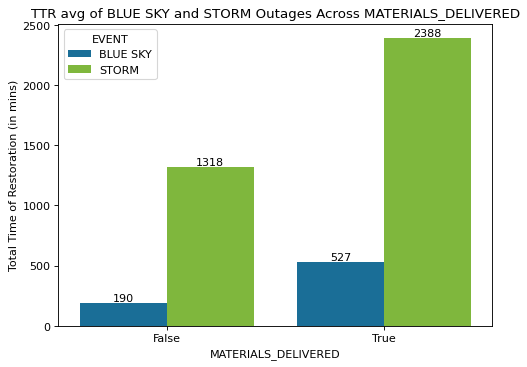

In [148]:
plt.figure(num = None,figsize=(7, 5),dpi=80,facecolor='w',edgecolor='k')

temp_df = df[['EVENT','MATERIALS_DELIVERED','TTR']]
temp_df = temp_df.groupby(['EVENT','MATERIALS_DELIVERED'],as_index = False).agg({'TTR':'mean'})

ax = sns.barplot(x = temp_df['MATERIALS_DELIVERED'],y = temp_df['TTR'],hue = temp_df['EVENT'],palette = ['#0575ac', '#81cb29'])
ax.set(xlabel = 'MATERIALS_DELIVERED', ylabel = 'Total Time of Restoration (in mins)')
ax.set_title('TTR avg of BLUE SKY and STORM Outages Across MATERIALS_DELIVERED')
for p in ax.patches:
    x=p.get_bbox().get_points()[:,0]
    y=p.get_bbox().get_points()[1,1]
    ax.annotate('{:.0f}'.format(y), (x.mean(), y), 
            ha='center', va='bottom') # set the alignment of the text
ax.grid(False)  

## Avg TTR across CALLED_CUSTOMER_OK 

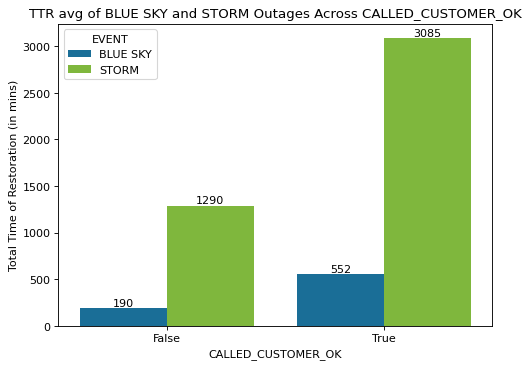

In [149]:
plt.figure(num = None,figsize=(7, 5),dpi=80,facecolor='w',edgecolor='k')

temp_df = df[['EVENT','CALLED_CUSTOMER_OK','TTR']]
temp_df = temp_df.groupby(['EVENT','CALLED_CUSTOMER_OK'],as_index = False).agg({'TTR':'mean'})

ax = sns.barplot(x = temp_df['CALLED_CUSTOMER_OK'],y = temp_df['TTR'],hue = temp_df['EVENT'],palette = ['#0575ac', '#81cb29'])
ax.set(xlabel = 'CALLED_CUSTOMER_OK', ylabel = 'Total Time of Restoration (in mins)')
ax.set_title('TTR avg of BLUE SKY and STORM Outages Across CALLED_CUSTOMER_OK')
for p in ax.patches:
    x=p.get_bbox().get_points()[:,0]
    y=p.get_bbox().get_points()[1,1]
    ax.annotate('{:.0f}'.format(y), (x.mean(), y), 
            ha='center', va='bottom') # set the alignment of the text
ax.grid(False)  

## Avg TTR across CREW_NEEDS_HELP 

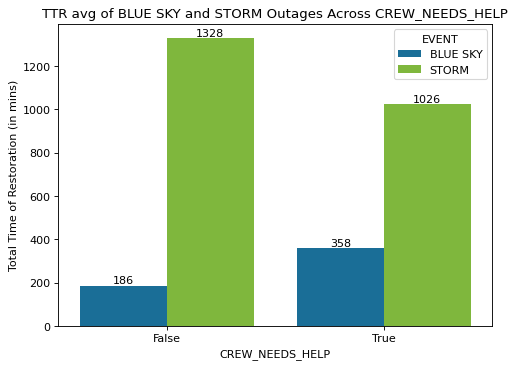

In [150]:
plt.figure(num = None,figsize=(7, 5),dpi=80,facecolor='w',edgecolor='k')

temp_df = df[['EVENT','CREW_NEEDS_HELP','TTR']]
temp_df = temp_df.groupby(['EVENT','CREW_NEEDS_HELP'],as_index = False).agg({'TTR':'mean'})

ax = sns.barplot(x = temp_df['CREW_NEEDS_HELP'],y = temp_df['TTR'],hue = temp_df['EVENT'],palette = ['#0575ac', '#81cb29'])
ax.set(xlabel = 'CREW_NEEDS_HELP', ylabel = 'Total Time of Restoration (in mins)')
ax.set_title('TTR avg of BLUE SKY and STORM Outages Across CREW_NEEDS_HELP')
for p in ax.patches:
    x=p.get_bbox().get_points()[:,0]
    y=p.get_bbox().get_points()[1,1]
    ax.annotate('{:.0f}'.format(y), (x.mean(), y), 
            ha='center', va='bottom') # set the alignment of the text
ax.grid(False)  

## Avg TTR across PUBLIC_SAFETY 

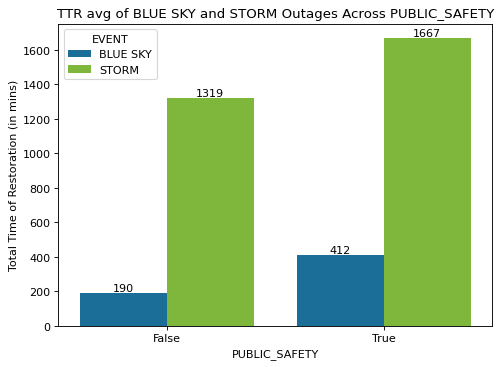

In [151]:
plt.figure(num = None,figsize=(7, 5),dpi=80,facecolor='w',edgecolor='k')

temp_df = df[['EVENT','PUBLIC_SAFETY','TTR']]
temp_df = temp_df.groupby(['EVENT','PUBLIC_SAFETY'],as_index = False).agg({'TTR':'mean'})

ax = sns.barplot(x = temp_df['PUBLIC_SAFETY'],y = temp_df['TTR'],hue = temp_df['EVENT'],palette = ['#0575ac', '#81cb29'])
ax.set(xlabel = 'PUBLIC_SAFETY', ylabel = 'Total Time of Restoration (in mins)')
ax.set_title('TTR avg of BLUE SKY and STORM Outages Across PUBLIC_SAFETY')
for p in ax.patches:
    x=p.get_bbox().get_points()[:,0]
    y=p.get_bbox().get_points()[1,1]
    ax.annotate('{:.0f}'.format(y), (x.mean(), y), 
            ha='center', va='bottom') # set the alignment of the text
ax.grid(False)  

## Avg TTR across HYDRO_VAC_NEEDED 

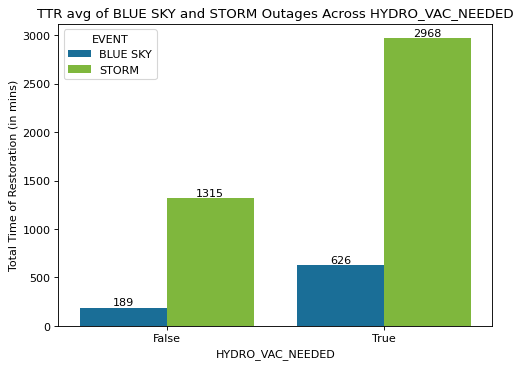

In [152]:
plt.figure(num = None,figsize=(7, 5),dpi=80,facecolor='w',edgecolor='k')

temp_df = df[['EVENT','HYDRO_VAC_NEEDED','TTR']]
temp_df = temp_df.groupby(['EVENT','HYDRO_VAC_NEEDED'],as_index = False).agg({'TTR':'mean'})

ax = sns.barplot(x = temp_df['HYDRO_VAC_NEEDED'],y = temp_df['TTR'],hue = temp_df['EVENT'],palette = ['#0575ac', '#81cb29'])
ax.set(xlabel = 'HYDRO_VAC_NEEDED', ylabel = 'Total Time of Restoration (in mins)')
ax.set_title('TTR avg of BLUE SKY and STORM Outages Across HYDRO_VAC_NEEDED')
for p in ax.patches:
    x=p.get_bbox().get_points()[:,0]
    y=p.get_bbox().get_points()[1,1]
    ax.annotate('{:.0f}'.format(y), (x.mean(), y), 
            ha='center', va='bottom') # set the alignment of the text
ax.grid(False)  

## Avg TTR across HYDRO_VAC_DISPATCHED 

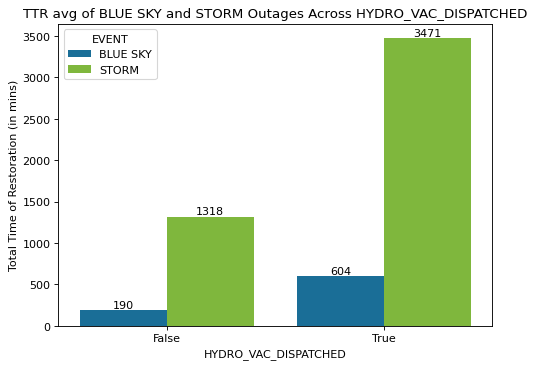

In [153]:
plt.figure(num = None,figsize=(7, 5),dpi=80,facecolor='w',edgecolor='k')

temp_df = df[['EVENT','HYDRO_VAC_DISPATCHED','TTR']]
temp_df = temp_df.groupby(['EVENT','HYDRO_VAC_DISPATCHED'],as_index = False).agg({'TTR':'mean'})

ax = sns.barplot(x = temp_df['HYDRO_VAC_DISPATCHED'],y = temp_df['TTR'],hue = temp_df['EVENT'],palette = ['#0575ac', '#81cb29'])
ax.set(xlabel = 'HYDRO_VAC_DISPATCHED', ylabel = 'Total Time of Restoration (in mins)')
ax.set_title('TTR avg of BLUE SKY and STORM Outages Across HYDRO_VAC_DISPATCHED')
for p in ax.patches:
    x=p.get_bbox().get_points()[:,0]
    y=p.get_bbox().get_points()[1,1]
    ax.annotate('{:.0f}'.format(y), (x.mean(), y), 
            ha='center', va='bottom') # set the alignment of the text
ax.grid(False)  

## Avg TTR across HYDRO_VAC_COMPLETED

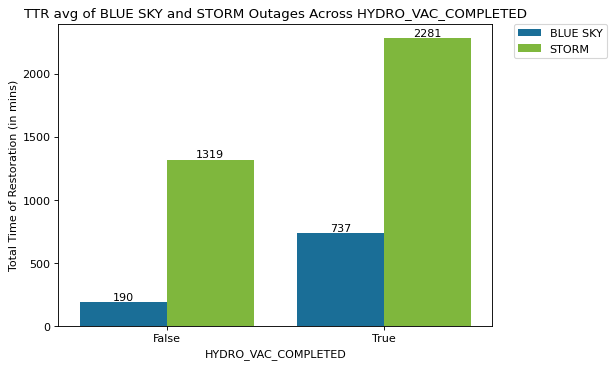

In [154]:
plt.figure(num = None,figsize=(7, 5),dpi=80,facecolor='w',edgecolor='k')

temp_df = df[['EVENT','HYDRO_VAC_COMPLETED','TTR']]
temp_df = temp_df.groupby(['EVENT','HYDRO_VAC_COMPLETED'],as_index = False).agg({'TTR':'mean'})

ax = sns.barplot(x = temp_df['HYDRO_VAC_COMPLETED'],y = temp_df['TTR'],hue = temp_df['EVENT'],palette = ['#0575ac', '#81cb29'])
ax.set(xlabel = 'HYDRO_VAC_COMPLETED', ylabel = 'Total Time of Restoration (in mins)')
ax.set_title('TTR avg of BLUE SKY and STORM Outages Across HYDRO_VAC_COMPLETED')
for p in ax.patches:
    x=p.get_bbox().get_points()[:,0]
    y=p.get_bbox().get_points()[1,1]
    ax.annotate('{:.0f}'.format(y), (x.mean(), y), 
            ha='center', va='bottom') # set the alignment of the text
ax.grid(False)  
# Put the legend out of the figure
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

## Avg TTR across PREFERRED_TREE_CREW_FLG 

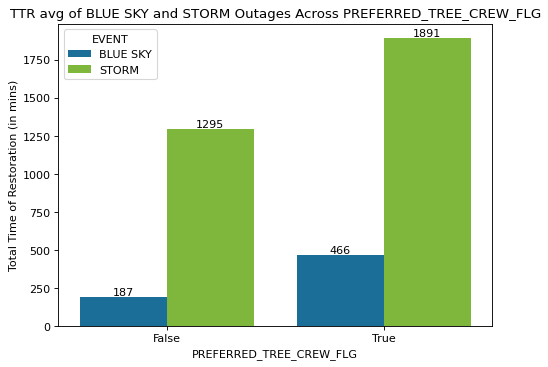

In [155]:
plt.figure(num = None,figsize=(7, 5),dpi=80,facecolor='w',edgecolor='k')

temp_df = df[['EVENT','PREFERRED_TREE_CREW_FLG','TTR']]
temp_df = temp_df.groupby(['EVENT','PREFERRED_TREE_CREW_FLG'],as_index = False).agg({'TTR':'mean'})

ax = sns.barplot(x = temp_df['PREFERRED_TREE_CREW_FLG'],y = temp_df['TTR'],hue = temp_df['EVENT'],palette = ['#0575ac', '#81cb29'])
ax.set(xlabel = 'PREFERRED_TREE_CREW_FLG', ylabel = 'Total Time of Restoration (in mins)')
ax.set_title('TTR avg of BLUE SKY and STORM Outages Across PREFERRED_TREE_CREW_FLG')
for p in ax.patches:
    x=p.get_bbox().get_points()[:,0]
    y=p.get_bbox().get_points()[1,1]
    ax.annotate('{:.0f}'.format(y), (x.mean(), y), 
            ha='center', va='bottom') # set the alignment of the text
ax.grid(False)  

## Avg TTR across PREFERRED_SCOUT_CREW_FLG 

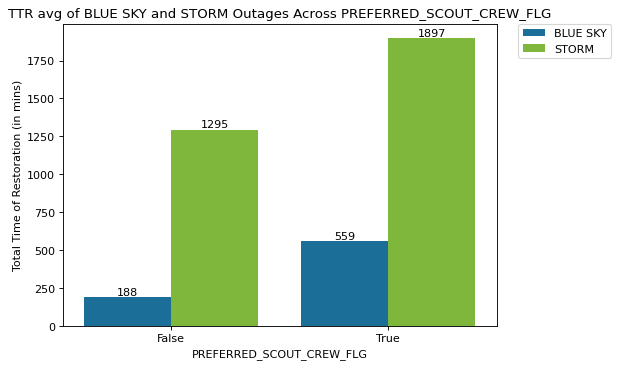

In [156]:
plt.figure(num = None,figsize=(7, 5),dpi=80,facecolor='w',edgecolor='k')

temp_df = df[['EVENT','PREFERRED_SCOUT_CREW_FLG','TTR']]
temp_df = temp_df.groupby(['EVENT','PREFERRED_SCOUT_CREW_FLG'],as_index = False).agg({'TTR':'mean'})

ax = sns.barplot(x = temp_df['PREFERRED_SCOUT_CREW_FLG'],y = temp_df['TTR'],hue = temp_df['EVENT'],palette = ['#0575ac', '#81cb29'])
ax.set(xlabel = 'PREFERRED_SCOUT_CREW_FLG', ylabel = 'Total Time of Restoration (in mins)')
ax.set_title('TTR avg of BLUE SKY and STORM Outages Across PREFERRED_SCOUT_CREW_FLG')
for p in ax.patches:
    x=p.get_bbox().get_points()[:,0]
    y=p.get_bbox().get_points()[1,1]
    ax.annotate('{:.0f}'.format(y), (x.mean(), y), 
            ha='center', va='bottom') # set the alignment of the text
ax.grid(False)  
# Put the legend out of the figure
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

## Avg TTR across ACCOUNT_TYPE_COM 

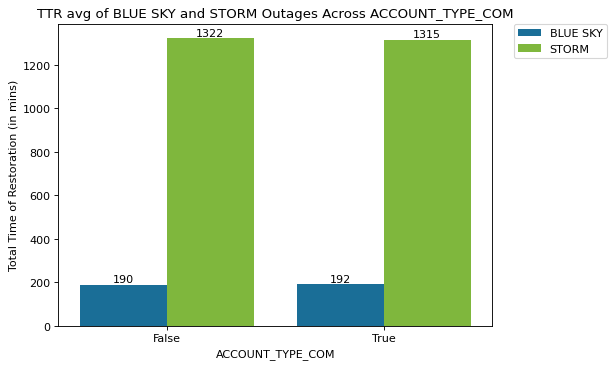

In [157]:
plt.figure(num = None,figsize=(7, 5),dpi=80,facecolor='w',edgecolor='k')

temp_df = df[['EVENT','ACCOUNT_TYPE_COM','TTR']]
temp_df = temp_df.groupby(['EVENT','ACCOUNT_TYPE_COM'],as_index = False).agg({'TTR':'mean'})

ax = sns.barplot(x = temp_df['ACCOUNT_TYPE_COM'],y = temp_df['TTR'],hue = temp_df['EVENT'],palette = ['#0575ac', '#81cb29'])
ax.set(xlabel = 'ACCOUNT_TYPE_COM', ylabel = 'Total Time of Restoration (in mins)')
ax.set_title('TTR avg of BLUE SKY and STORM Outages Across ACCOUNT_TYPE_COM')
for p in ax.patches:
    x=p.get_bbox().get_points()[:,0]
    y=p.get_bbox().get_points()[1,1]
    ax.annotate('{:.0f}'.format(y), (x.mean(), y), 
            ha='center', va='bottom') # set the alignment of the text
ax.grid(False)  
# Put the legend out of the figure
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

## Avg TTR across ACCOUNT_TYPE_CUS 

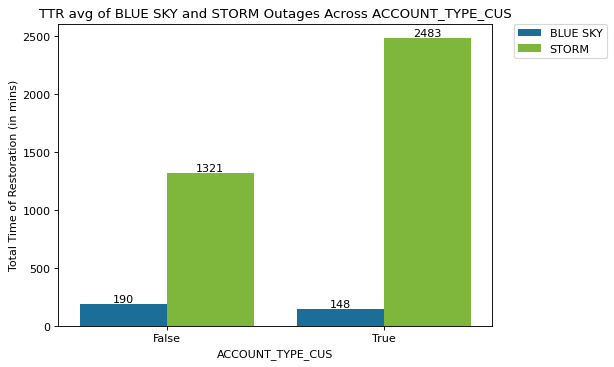

In [158]:
plt.figure(num = None,figsize=(7, 5),dpi=80,facecolor='w',edgecolor='k')

temp_df = df[['EVENT','ACCOUNT_TYPE_CUS','TTR']]
temp_df = temp_df.groupby(['EVENT','ACCOUNT_TYPE_CUS'],as_index = False).agg({'TTR':'mean'})

ax = sns.barplot(x = temp_df['ACCOUNT_TYPE_CUS'],y = temp_df['TTR'],hue = temp_df['EVENT'],palette = ['#0575ac', '#81cb29'])
ax.set(xlabel = 'ACCOUNT_TYPE_CUS', ylabel = 'Total Time of Restoration (in mins)')
ax.set_title('TTR avg of BLUE SKY and STORM Outages Across ACCOUNT_TYPE_CUS')
for p in ax.patches:
    x=p.get_bbox().get_points()[:,0]
    y=p.get_bbox().get_points()[1,1]
    ax.annotate('{:.0f}'.format(y), (x.mean(), y), 
            ha='center', va='bottom') # set the alignment of the text
ax.grid(False)  
# Put the legend out of the figure
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

## Avg TTR across ACCOUNT_TYPE_GOV 

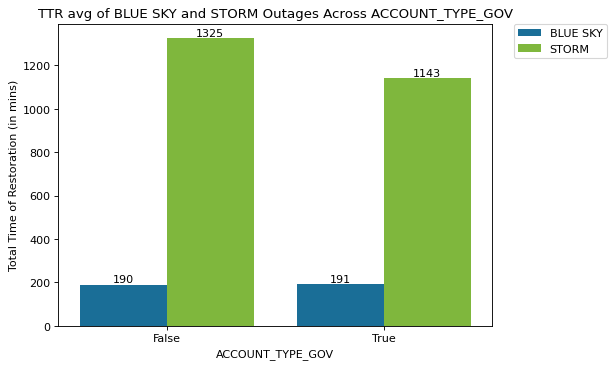

In [159]:
plt.figure(num = None,figsize=(7, 5),dpi=80,facecolor='w',edgecolor='k')

temp_df = df[['EVENT','ACCOUNT_TYPE_GOV','TTR']]
temp_df = temp_df.groupby(['EVENT','ACCOUNT_TYPE_GOV'],as_index = False).agg({'TTR':'mean'})

ax = sns.barplot(x = temp_df['ACCOUNT_TYPE_GOV'],y = temp_df['TTR'],hue = temp_df['EVENT'],palette = ['#0575ac', '#81cb29'])
ax.set(xlabel = 'ACCOUNT_TYPE_GOV', ylabel = 'Total Time of Restoration (in mins)')
ax.set_title('TTR avg of BLUE SKY and STORM Outages Across ACCOUNT_TYPE_GOV')
for p in ax.patches:
    x=p.get_bbox().get_points()[:,0]
    y=p.get_bbox().get_points()[1,1]
    ax.annotate('{:.0f}'.format(y), (x.mean(), y), 
            ha='center', va='bottom') # set the alignment of the text
ax.grid(False)  
# Put the legend out of the figure
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

## Avg TTR across ACCOUNT_TYPE_IND 

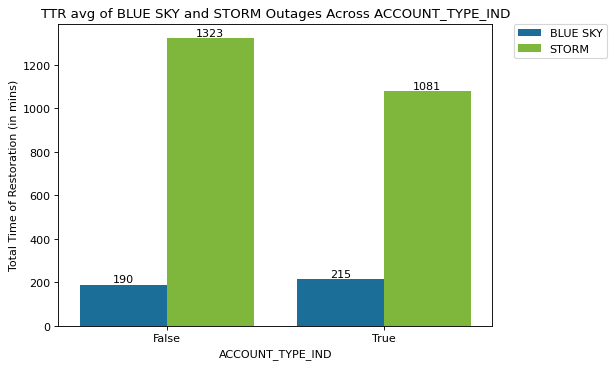

In [160]:
plt.figure(num = None,figsize=(7, 5),dpi=80,facecolor='w',edgecolor='k')

temp_df = df[['EVENT','ACCOUNT_TYPE_IND','TTR']]
temp_df = temp_df.groupby(['EVENT','ACCOUNT_TYPE_IND'],as_index = False).agg({'TTR':'mean'})

ax = sns.barplot(x = temp_df['ACCOUNT_TYPE_IND'],y = temp_df['TTR'],hue = temp_df['EVENT'],palette = ['#0575ac', '#81cb29'])
ax.set(xlabel = 'ACCOUNT_TYPE_IND', ylabel = 'Total Time of Restoration (in mins)')
ax.set_title('TTR avg of BLUE SKY and STORM Outages Across ACCOUNT_TYPE_IND')
for p in ax.patches:
    x=p.get_bbox().get_points()[:,0]
    y=p.get_bbox().get_points()[1,1]
    ax.annotate('{:.0f}'.format(y), (x.mean(), y), 
            ha='center', va='bottom') # set the alignment of the text
ax.grid(False)  
# Put the legend out of the figure
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

## Avg TTR across ACCOUNT_TYPE_RES 

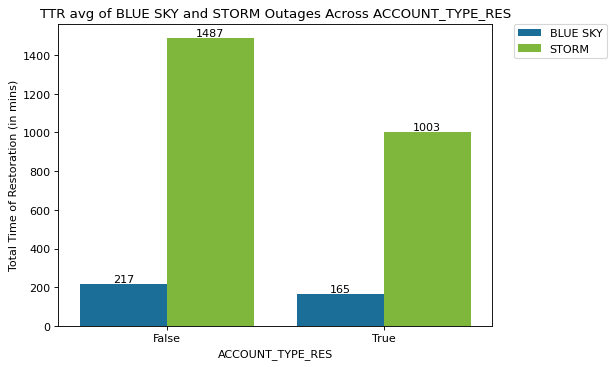

In [161]:
plt.figure(num = None,figsize=(7, 5),dpi=80,facecolor='w',edgecolor='k')

temp_df = df[['EVENT','ACCOUNT_TYPE_RES','TTR']]
temp_df = temp_df.groupby(['EVENT','ACCOUNT_TYPE_RES'],as_index = False).agg({'TTR':'mean'})

ax = sns.barplot(x = temp_df['ACCOUNT_TYPE_RES'],y = temp_df['TTR'],hue = temp_df['EVENT'],palette = ['#0575ac', '#81cb29'])
ax.set(xlabel = 'ACCOUNT_TYPE_RES', ylabel = 'Total Time of Restoration (in mins)')
ax.set_title('TTR avg of BLUE SKY and STORM Outages Across ACCOUNT_TYPE_RES')
for p in ax.patches:
    x=p.get_bbox().get_points()[:,0]
    y=p.get_bbox().get_points()[1,1]
    ax.annotate('{:.0f}'.format(y), (x.mean(), y), 
            ha='center', va='bottom') # set the alignment of the text
ax.grid(False)  
# Put the legend out of the figure
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

## Account type

In [162]:
temp_df = pd.DataFrame()
temp_df['ACCOUNT'] = ['ACCOUNT_TYPE_COM', 'ACCOUNT_TYPE_CUS','ACCOUNT_TYPE_GOV','ACCOUNT_TYPE_IND','ACCOUNT_TYPE_RES',
                   'ACCOUNT_TYPE_COM', 'ACCOUNT_TYPE_CUS','ACCOUNT_TYPE_GOV','ACCOUNT_TYPE_IND','ACCOUNT_TYPE_RES']
temp_df['EVENT'] = ['BLUE SKY','BLUE SKY','BLUE SKY','BLUE SKY','BLUE SKY','STORM','STORM','STORM','STORM','STORM']
mean_ttr = []
count = []
for i in range(len(temp_df[temp_df['EVENT'] == 'BLUE SKY'])):
    x = df[(df.EVENT == 'BLUE SKY') & (df[temp_df.ACCOUNT[i]] == True)].TTR.mean()
    mean_ttr.append(x)
    x = df[(df.EVENT == 'BLUE SKY') & (df[temp_df.ACCOUNT[i]] == True)].TTR.count()
    count.append(x)
    
for i in range(len(temp_df[temp_df['EVENT'] == 'STORM'])):
    x = df[(df.EVENT == 'STORM') & (df[temp_df.ACCOUNT[i]] == True)].TTR.mean()
    mean_ttr.append(x)
    x = df[(df.EVENT == 'STORM') & (df[temp_df.ACCOUNT[i]] == True)].TTR.count()
    count.append(x)
    
temp_df['Mean_ttr'] = mean_ttr
temp_df['#Outages'] = count

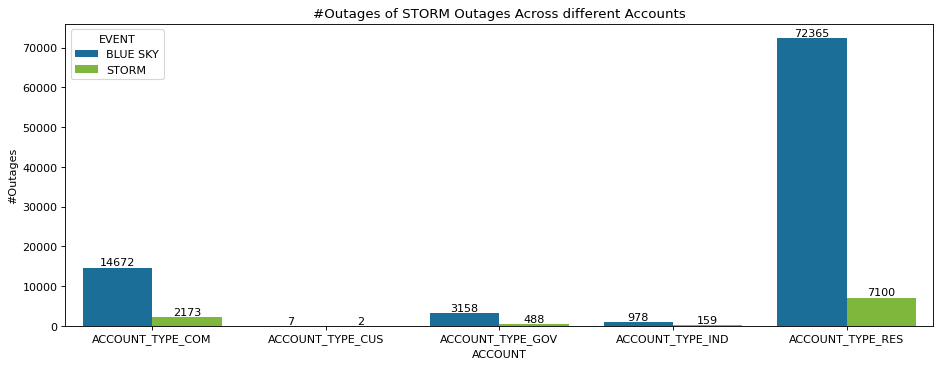

In [163]:
plt.figure(num = None,figsize=(14, 5),dpi=80,facecolor='w',edgecolor='k')
ax = sns.barplot(x = temp_df['ACCOUNT'],y = temp_df['#Outages'],hue = temp_df['EVENT'],palette = ['#0575ac', '#81cb29'])
ax.set(xlabel = 'ACCOUNT', ylabel = '#Outages')
ax.set_title('#Outages of STORM Outages Across different Accounts')
for p in ax.patches:
    x=p.get_bbox().get_points()[:,0]
    y=p.get_bbox().get_points()[1,1]
    ax.annotate('{:.0f}'.format(y), (x.mean(), y), 
            ha='center', va='bottom') # set the alignment of the text
ax.grid(False)  

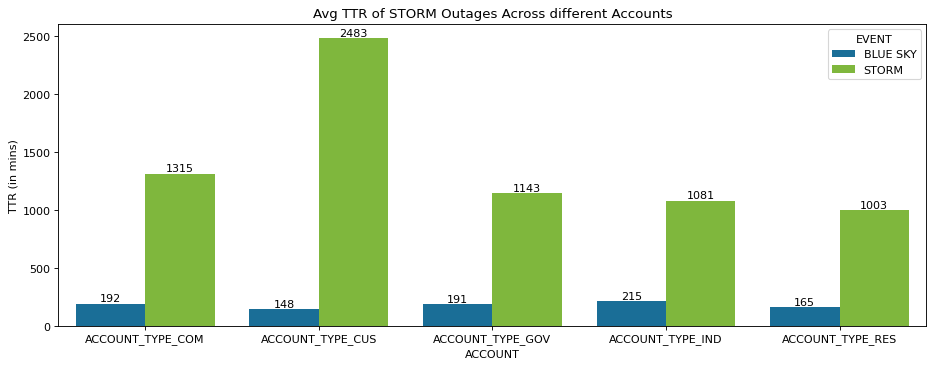

In [164]:
plt.figure(num = None,figsize=(14, 5),dpi=80,facecolor='w',edgecolor='k')
ax = sns.barplot(x = temp_df['ACCOUNT'],y = temp_df['Mean_ttr'],hue = temp_df['EVENT'],palette = ['#0575ac', '#81cb29'])
ax.set(xlabel = 'ACCOUNT', ylabel = 'TTR (in mins)')
ax.set_title('Avg TTR of STORM Outages Across different Accounts')
for p in ax.patches:
    x=p.get_bbox().get_points()[:,0]
    y=p.get_bbox().get_points()[1,1]
    ax.annotate('{:.0f}'.format(y), (x.mean(), y), 
            ha='center', va='bottom') # set the alignment of the text
ax.grid(False)  

## Avg TTR across Day_flag

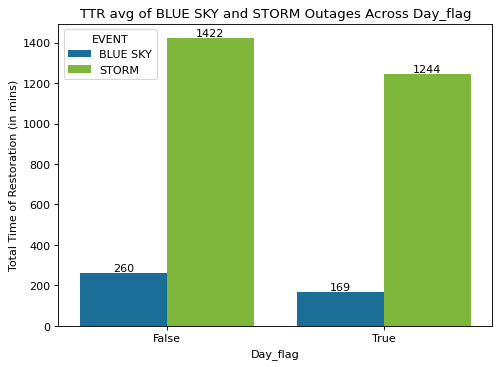

In [165]:
plt.figure(num = None,figsize=(7, 5),dpi=80,facecolor='w',edgecolor='k')

temp_df = df[['EVENT','Day_flag','TTR']]
temp_df = temp_df.groupby(['EVENT','Day_flag'],as_index = False).agg({'TTR':'mean'})

ax = sns.barplot(x = temp_df['Day_flag'],y = temp_df['TTR'],hue = temp_df['EVENT'],palette = ['#0575ac', '#81cb29'])
ax.set(xlabel = 'Day_flag', ylabel = 'Total Time of Restoration (in mins)')
ax.set_title('TTR avg of BLUE SKY and STORM Outages Across Day_flag')
for p in ax.patches:
    x=p.get_bbox().get_points()[:,0]
    y=p.get_bbox().get_points()[1,1]
    ax.annotate('{:.0f}'.format(y), (x.mean(), y), 
            ha='center', va='bottom') # set the alignment of the text
ax.grid(False)  

## Avg TTR across weekdays

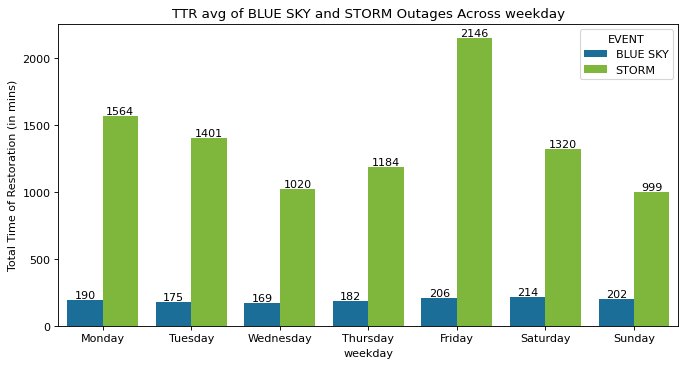

In [166]:
plt.figure(num = None,figsize=(10, 5),dpi=80,facecolor='w',edgecolor='k')

temp_df = df[['EVENT','weekday','TTR']]
temp_df = temp_df.groupby(['EVENT','weekday'],as_index = False).agg({'TTR':'mean'})

ax = sns.barplot(x = temp_df['weekday'],y = temp_df['TTR'],hue = temp_df['EVENT'],palette = ['#0575ac', '#81cb29'], order= ["Monday", "Tuesday",
                                                                                                                            "Wednesday", "Thursday", 
                                                                                                                            "Friday", "Saturday", "Sunday"])
ax.set(xlabel = 'weekday', ylabel = 'Total Time of Restoration (in mins)')
ax.set_title('TTR avg of BLUE SKY and STORM Outages Across weekday')
for p in ax.patches:
    x=p.get_bbox().get_points()[:,0]
    y=p.get_bbox().get_points()[1,1]
    ax.annotate('{:.0f}'.format(y), (x.mean(), y), 
            ha='center', va='bottom') # set the alignment of the text
ax.grid(False)  

## Outages across weekdays

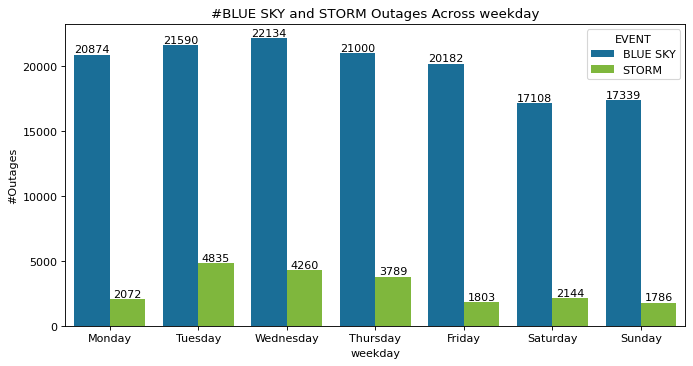

In [167]:
plt.figure(num = None,figsize=(10, 5),dpi=80,facecolor='w',edgecolor='k')

temp_df = df[['EVENT','weekday','TTR']]
temp_df = temp_df.groupby(['EVENT','weekday'],as_index = False).agg({'TTR':'count'})

ax = sns.barplot(x = temp_df['weekday'],y = temp_df['TTR'],hue = temp_df['EVENT'],palette = ['#0575ac', '#81cb29'], order= ["Monday", "Tuesday",
                                                                                                                            "Wednesday", "Thursday", 
                                                                                                                            "Friday", "Saturday", "Sunday"])
ax.set(xlabel = 'weekday', ylabel = '#Outages')
ax.set_title('#BLUE SKY and STORM Outages Across weekday')
for p in ax.patches:
    x=p.get_bbox().get_points()[:,0]
    y=p.get_bbox().get_points()[1,1]
    ax.annotate('{:.0f}'.format(y), (x.mean(), y), 
            ha='center', va='bottom') # set the alignment of the text
ax.grid(False)  

### Avg Crew size across days

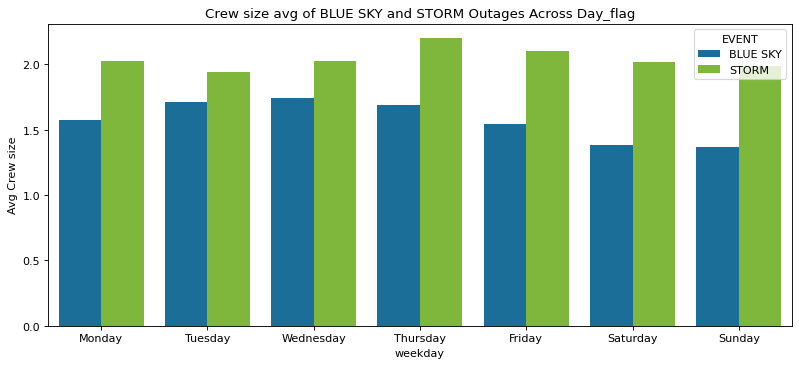

In [168]:
plt.figure(num = None,figsize=(12, 5),dpi=80,facecolor='w',edgecolor='k')

temp_df = df[['EVENT','weekday','CREWSIZE']]
temp_df = temp_df.groupby(['EVENT','weekday'],as_index = False).agg({'CREWSIZE':'mean'})

ax = sns.barplot(x = temp_df['weekday'],y = temp_df['CREWSIZE'],hue = temp_df['EVENT'],palette = ['#0575ac', '#81cb29'],order= ["Monday", "Tuesday",
                                                                                                                            "Wednesday", "Thursday", 
                                                                                                                            "Friday", "Saturday", "Sunday"])
ax.set(xlabel = 'weekday', ylabel = 'Avg Crew size')

ax.set_title('Crew size avg of BLUE SKY and STORM Outages Across Day_flag')
ax.grid(False)  

### Outages across hour bucket

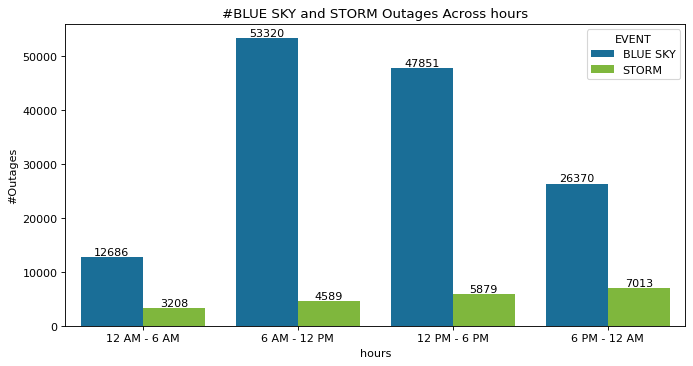

In [169]:
plt.figure(num = None,figsize=(10, 5),dpi=80,facecolor='w',edgecolor='k')

temp_df = df[['EVENT','TIME_OF_FIRST_CALL','TTR']]
temp_df['hour'] = temp_df['TIME_OF_FIRST_CALL'].dt.hour
temp_df['hour'] = temp_df['hour'].apply(lambda x: '6 AM - 12 PM' if (x >=6) & (x <12) else ('12 PM - 6 PM' if (x >=12) & (x < 18) else ('6 PM - 12 AM' if (x >=18) & (x < 24) else '12 AM - 6 AM')))
temp_df = temp_df.groupby(['EVENT','hour'],as_index = False).agg({'TTR':'count'})

ax = sns.barplot(x = temp_df['hour'],y = temp_df['TTR'],hue = temp_df['EVENT'],palette = ['#0575ac', '#81cb29'],order= ['12 AM - 6 AM','6 AM - 12 PM',
                                                                                                                      '12 PM - 6 PM','6 PM - 12 AM'])
ax.set(xlabel = 'hours', ylabel = '#Outages')
ax.set_title('#BLUE SKY and STORM Outages Across hours')
for p in ax.patches:
    x=p.get_bbox().get_points()[:,0]
    y=p.get_bbox().get_points()[1,1]
    ax.annotate('{:.0f}'.format(y), (x.mean(), y), 
            ha='center', va='bottom') # set the alignment of the text
ax.grid(False)  

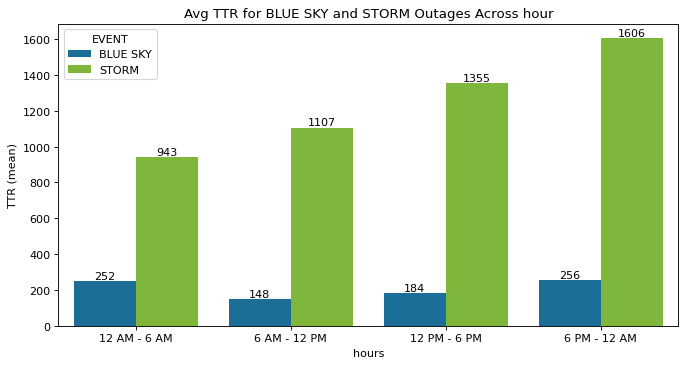

In [170]:
plt.figure(num = None,figsize=(10, 5),dpi=80,facecolor='w',edgecolor='k')

temp_df = df[['EVENT','TIME_OF_FIRST_CALL','TTR']]
temp_df['hour'] = temp_df['TIME_OF_FIRST_CALL'].dt.hour
temp_df['hour'] = temp_df['hour'].apply(lambda x: '6 AM - 12 PM' if (x >=6) & (x <12) else ('12 PM - 6 PM' if (x >=12) & (x < 18) else ('6 PM - 12 AM' if (x >=18) & (x < 24) else '12 AM - 6 AM')))
temp_df = temp_df.groupby(['EVENT','hour'],as_index = False).agg({'TTR':'mean'})

ax = sns.barplot(x = temp_df['hour'],y = temp_df['TTR'],hue = temp_df['EVENT'],palette = ['#0575ac', '#81cb29'],order= ['12 AM - 6 AM','6 AM - 12 PM',
                                                                                                                      '12 PM - 6 PM','6 PM - 12 AM'])
ax.set(xlabel = 'hours', ylabel = 'TTR (mean)')
ax.set_title('Avg TTR for BLUE SKY and STORM Outages Across hour')
for p in ax.patches:
    x=p.get_bbox().get_points()[:,0]
    y=p.get_bbox().get_points()[1,1]
    ax.annotate('{:.0f}'.format(y), (x.mean(), y), 
            ha='center', va='bottom') # set the alignment of the text
ax.grid(False)  

## Service Center

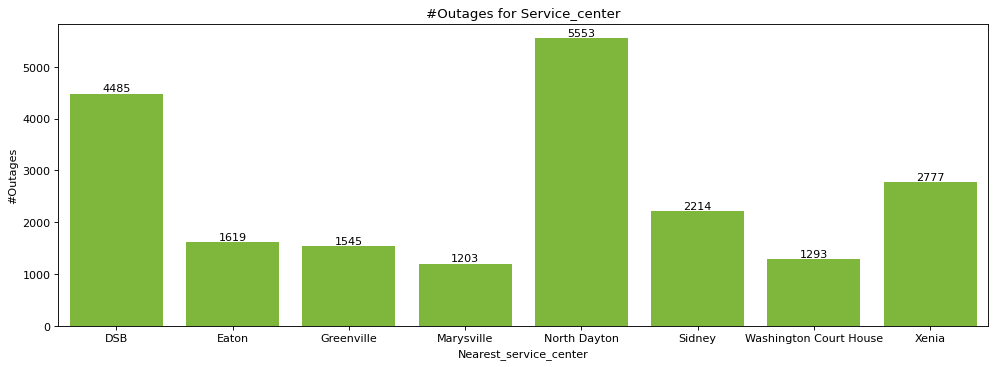

In [171]:
plt.figure(num = None,figsize=(15, 5),dpi=80,facecolor='w',edgecolor='k')

temp_df = df_storm[['Nearest_service_center','TTR']]
temp_df = temp_df.groupby(['Nearest_service_center'],as_index = False).agg({'TTR':'count'})

ax = sns.barplot(x = temp_df['Nearest_service_center'],y = temp_df['TTR'],palette = ['#81cb29'])
ax.set(xlabel = 'Nearest_service_center', ylabel = '#Outages')
ax.set_title('#Outages for Service_center')
for p in ax.patches:
    x=p.get_bbox().get_points()[:,0]
    y=p.get_bbox().get_points()[1,1]
    ax.annotate('{:.0f}'.format(y), (x.mean(), y), 
            ha='center', va='bottom') # set the alignment of the text
ax.grid(False)  

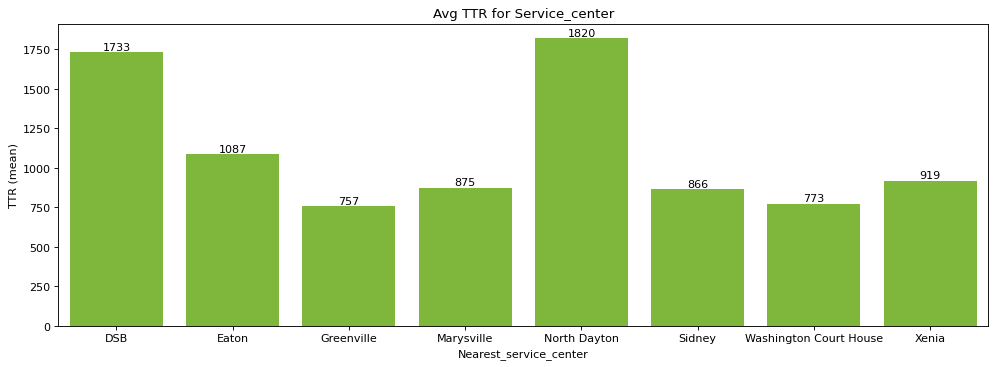

In [172]:
plt.figure(num = None,figsize=(15, 5),dpi=80,facecolor='w',edgecolor='k')

temp_df = df_storm[['Nearest_service_center','TTR']]
temp_df = temp_df.groupby(['Nearest_service_center'],as_index = False).agg({'TTR':'mean'})

ax = sns.barplot(x = temp_df['Nearest_service_center'],y = temp_df['TTR'],palette = ['#81cb29'])
ax.set(xlabel = 'Nearest_service_center', ylabel = 'TTR (mean)')
ax.set_title('Avg TTR for Service_center')
for p in ax.patches:
    x=p.get_bbox().get_points()[:,0]
    y=p.get_bbox().get_points()[1,1]
    ax.annotate('{:.0f}'.format(y), (x.mean(), y), 
            ha='center', va='bottom') # set the alignment of the text
ax.grid(False)  

### DSB

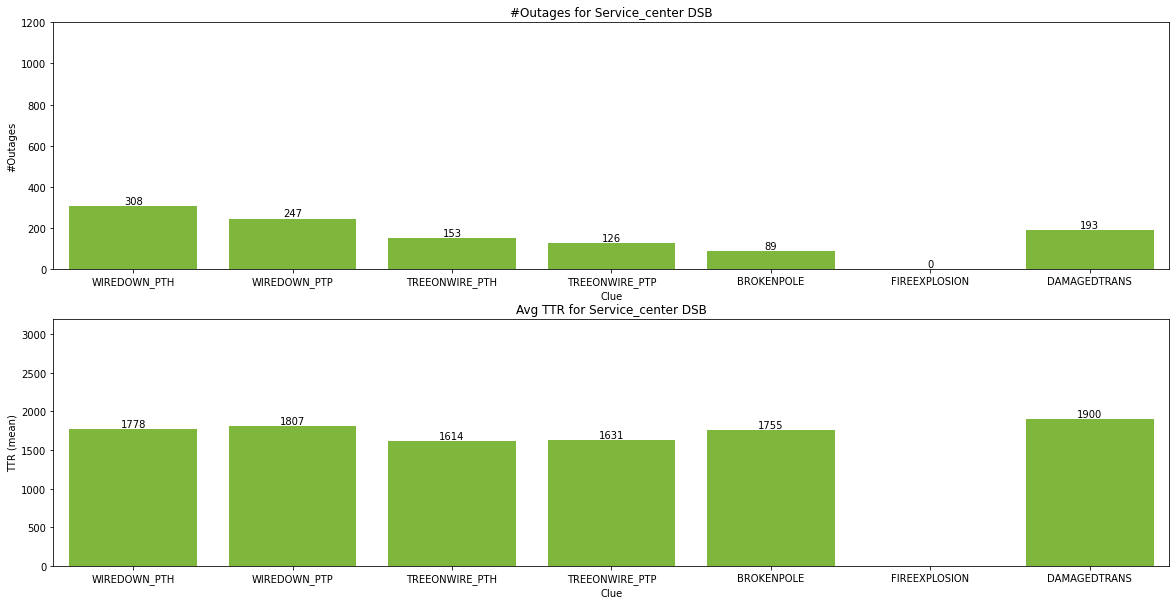

In [173]:
temp_df = pd.DataFrame()
temp_df['CLUE'] = ['WIREDOWN_PTH', 'WIREDOWN_PTP','TREEONWIRE_PTH','TREEONWIRE_PTP','BROKENPOLE','FIREEXPLOSION', 'DAMAGEDTRANS']
mean_ttr = []
count = []
for i in range(len(temp_df)):
    x = df_storm[(df_storm.Nearest_service_center == 'DSB') & (df[temp_df.CLUE[i]] == True)].TTR.mean()
    mean_ttr.append(x)
    x = df[(df_storm.Nearest_service_center == 'DSB') & (df[temp_df.CLUE[i]] == True)].TTR.count()
    count.append(x)

temp_df['Mean_ttr'] = mean_ttr
temp_df['#Outages'] = count

fig,ax =  plt.subplots(2,1,figsize=(20,10))
sns.barplot(x = temp_df['CLUE'],y = temp_df['#Outages'],palette = ['#81cb29'], ax = ax[0])
ax[0].set(xlabel = 'Clue', ylabel = '#Outages')
ax[0].set_title('#Outages for Service_center DSB')
ax[0].set(ylim=(0, 1200))
for p in ax[0].patches:
    x=p.get_bbox().get_points()[:,0]
    y=p.get_bbox().get_points()[1,1]
    ax[0].annotate('{:.0f}'.format(y), (x.mean(), y), 
            ha='center', va='bottom') # set the alignment of the text
ax[0].grid(False)  

sns.barplot(x = temp_df['CLUE'],y = temp_df['Mean_ttr'],palette = ['#81cb29'], ax = ax[1])
ax[1].set(xlabel = 'Clue', ylabel = 'TTR (mean)')
ax[1].set_title('Avg TTR for Service_center DSB')
ax[1].set(ylim=(0, 3200))
for p in ax[1].patches:
    x=p.get_bbox().get_points()[:,0]
    y=p.get_bbox().get_points()[1,1]
    ax[1].annotate('{:.0f}'.format(y), (x.mean(), y), 
            ha='center', va='bottom') # set the alignment of the text
ax[1].grid(False)  

### Washington Court House

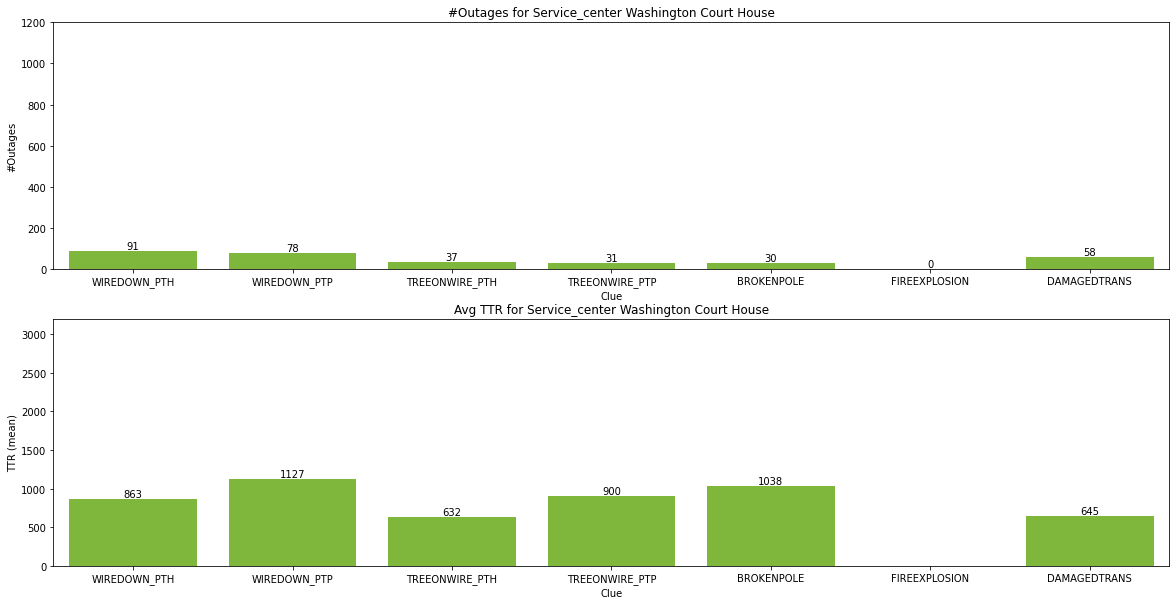

In [174]:
temp_df = pd.DataFrame()
temp_df['CLUE'] = ['WIREDOWN_PTH', 'WIREDOWN_PTP','TREEONWIRE_PTH','TREEONWIRE_PTP','BROKENPOLE','FIREEXPLOSION', 'DAMAGEDTRANS']
mean_ttr = []
count = []
for i in range(len(temp_df)):
    x = df_storm[(df_storm.Nearest_service_center == 'Washington Court House') & (df[temp_df.CLUE[i]] == True)].TTR.mean()
    mean_ttr.append(x)
    x = df[(df_storm.Nearest_service_center == 'Washington Court House') & (df[temp_df.CLUE[i]] == True)].TTR.count()
    count.append(x)

temp_df['Mean_ttr'] = mean_ttr
temp_df['#Outages'] = count

fig,ax =  plt.subplots(2,1,figsize=(20,10))
sns.barplot(x = temp_df['CLUE'],y = temp_df['#Outages'],palette = ['#81cb29'], ax = ax[0])
ax[0].set(xlabel = 'Clue', ylabel = '#Outages')
ax[0].set_title('#Outages for Service_center Washington Court House')
ax[0].set(ylim=(0, 1200))
for p in ax[0].patches:
    x=p.get_bbox().get_points()[:,0]
    y=p.get_bbox().get_points()[1,1]
    ax[0].annotate('{:.0f}'.format(y), (x.mean(), y), 
            ha='center', va='bottom') # set the alignment of the text
ax[0].grid(False)  

sns.barplot(x = temp_df['CLUE'],y = temp_df['Mean_ttr'],palette = ['#81cb29'], ax = ax[1])
ax[1].set(xlabel = 'Clue', ylabel = 'TTR (mean)')
ax[1].set_title('Avg TTR for Service_center Washington Court House')
ax[1].set(ylim=(0, 3200))
for p in ax[1].patches:
    x=p.get_bbox().get_points()[:,0]
    y=p.get_bbox().get_points()[1,1]
    ax[1].annotate('{:.0f}'.format(y), (x.mean(), y), 
            ha='center', va='bottom') # set the alignment of the text
ax[1].grid(False)  

### Marysville

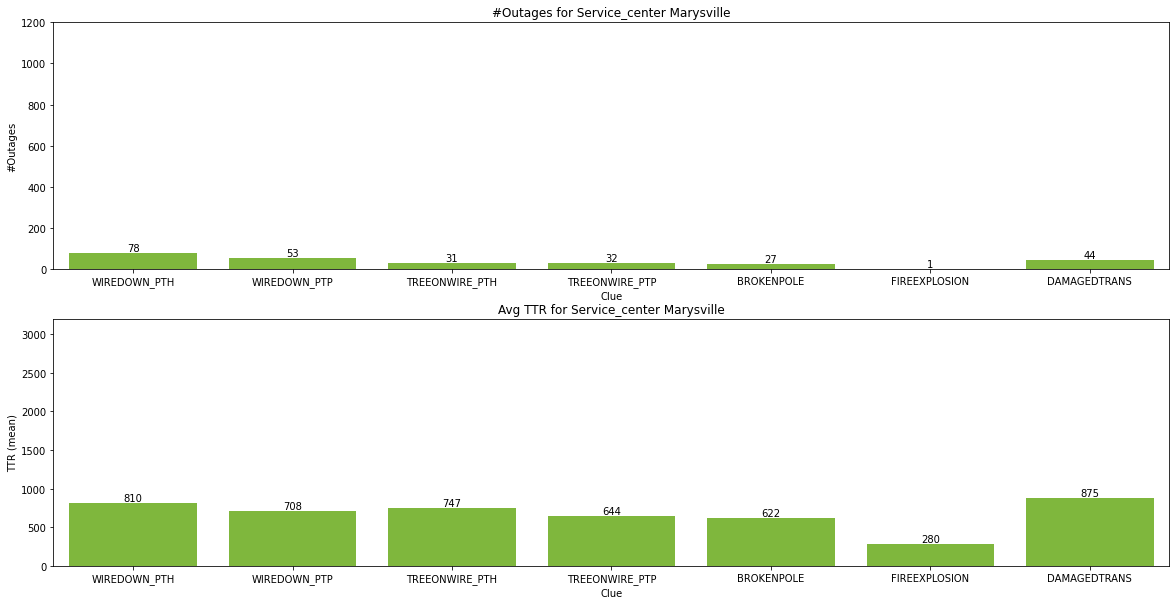

In [175]:
temp_df = pd.DataFrame()
temp_df['CLUE'] = ['WIREDOWN_PTH', 'WIREDOWN_PTP','TREEONWIRE_PTH','TREEONWIRE_PTP','BROKENPOLE','FIREEXPLOSION', 'DAMAGEDTRANS']
mean_ttr = []
count = []
for i in range(len(temp_df)):
    x = df_storm[(df_storm.Nearest_service_center == 'Marysville') & (df[temp_df.CLUE[i]] == True)].TTR.mean()
    mean_ttr.append(x)
    x = df[(df_storm.Nearest_service_center == 'Marysville') & (df[temp_df.CLUE[i]] == True)].TTR.count()
    count.append(x)

temp_df['Mean_ttr'] = mean_ttr
temp_df['#Outages'] = count

fig,ax =  plt.subplots(2,1,figsize=(20,10))
sns.barplot(x = temp_df['CLUE'],y = temp_df['#Outages'],palette = ['#81cb29'], ax = ax[0])
ax[0].set(xlabel = 'Clue', ylabel = '#Outages')
ax[0].set_title('#Outages for Service_center Marysville')
ax[0].set(ylim=(0, 1200))
for p in ax[0].patches:
    x=p.get_bbox().get_points()[:,0]
    y=p.get_bbox().get_points()[1,1]
    ax[0].annotate('{:.0f}'.format(y), (x.mean(), y), 
            ha='center', va='bottom') # set the alignment of the text
ax[0].grid(False)  

sns.barplot(x = temp_df['CLUE'],y = temp_df['Mean_ttr'],palette = ['#81cb29'], ax = ax[1])
ax[1].set(xlabel = 'Clue', ylabel = 'TTR (mean)')
ax[1].set_title('Avg TTR for Service_center Marysville')
ax[1].set(ylim=(0, 3200))
for p in ax[1].patches:
    x=p.get_bbox().get_points()[:,0]
    y=p.get_bbox().get_points()[1,1]
    ax[1].annotate('{:.0f}'.format(y), (x.mean(), y), 
            ha='center', va='bottom') # set the alignment of the text
ax[1].grid(False)  

### Xenia

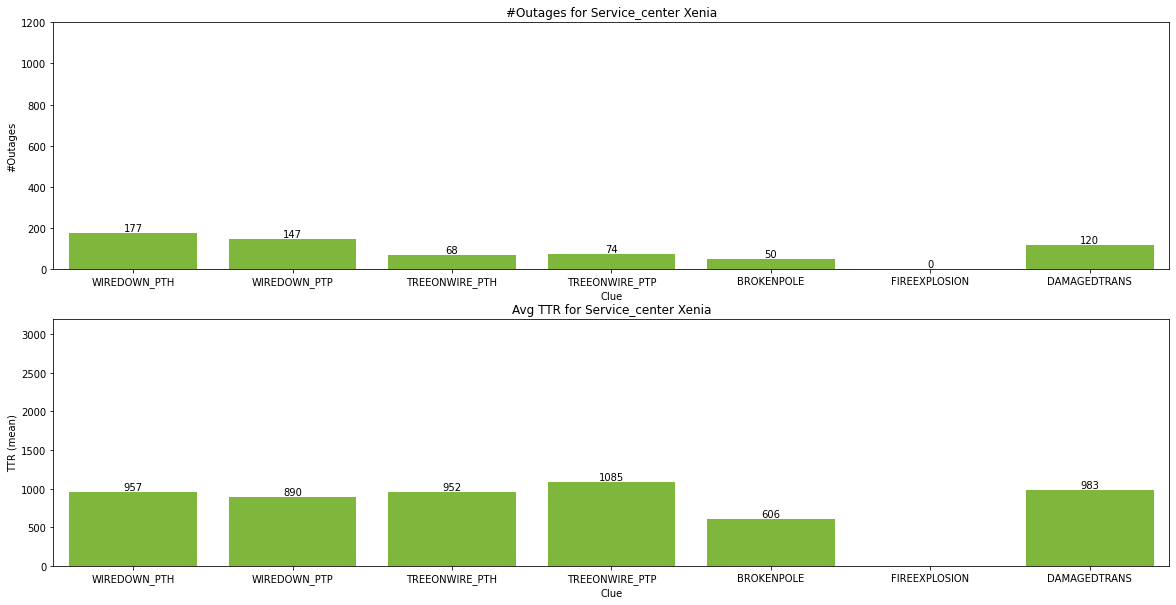

In [176]:
temp_df = pd.DataFrame()
temp_df['CLUE'] = ['WIREDOWN_PTH', 'WIREDOWN_PTP','TREEONWIRE_PTH','TREEONWIRE_PTP','BROKENPOLE','FIREEXPLOSION', 'DAMAGEDTRANS']
mean_ttr = []
count = []
for i in range(len(temp_df)):
    x = df_storm[(df_storm.Nearest_service_center == 'Xenia') & (df[temp_df.CLUE[i]] == True)].TTR.mean()
    mean_ttr.append(x)
    x = df[(df_storm.Nearest_service_center == 'Xenia') & (df[temp_df.CLUE[i]] == True)].TTR.count()
    count.append(x)

temp_df['Mean_ttr'] = mean_ttr
temp_df['#Outages'] = count

fig,ax =  plt.subplots(2,1,figsize=(20,10))
sns.barplot(x = temp_df['CLUE'],y = temp_df['#Outages'],palette = ['#81cb29'], ax = ax[0])
ax[0].set(xlabel = 'Clue', ylabel = '#Outages')
ax[0].set_title('#Outages for Service_center Xenia')
ax[0].set(ylim=(0, 1200))
for p in ax[0].patches:
    x=p.get_bbox().get_points()[:,0]
    y=p.get_bbox().get_points()[1,1]
    ax[0].annotate('{:.0f}'.format(y), (x.mean(), y), 
            ha='center', va='bottom') # set the alignment of the text
ax[0].grid(False)  

sns.barplot(x = temp_df['CLUE'],y = temp_df['Mean_ttr'],palette = ['#81cb29'], ax = ax[1])
ax[1].set(xlabel = 'Clue', ylabel = 'TTR (mean)')
ax[1].set_title('Avg TTR for Service_center Xenia')
ax[1].set(ylim=(0, 3200))
for p in ax[1].patches:
    x=p.get_bbox().get_points()[:,0]
    y=p.get_bbox().get_points()[1,1]
    ax[1].annotate('{:.0f}'.format(y), (x.mean(), y), 
            ha='center', va='bottom') # set the alignment of the text
ax[1].grid(False)  

### North Dayton

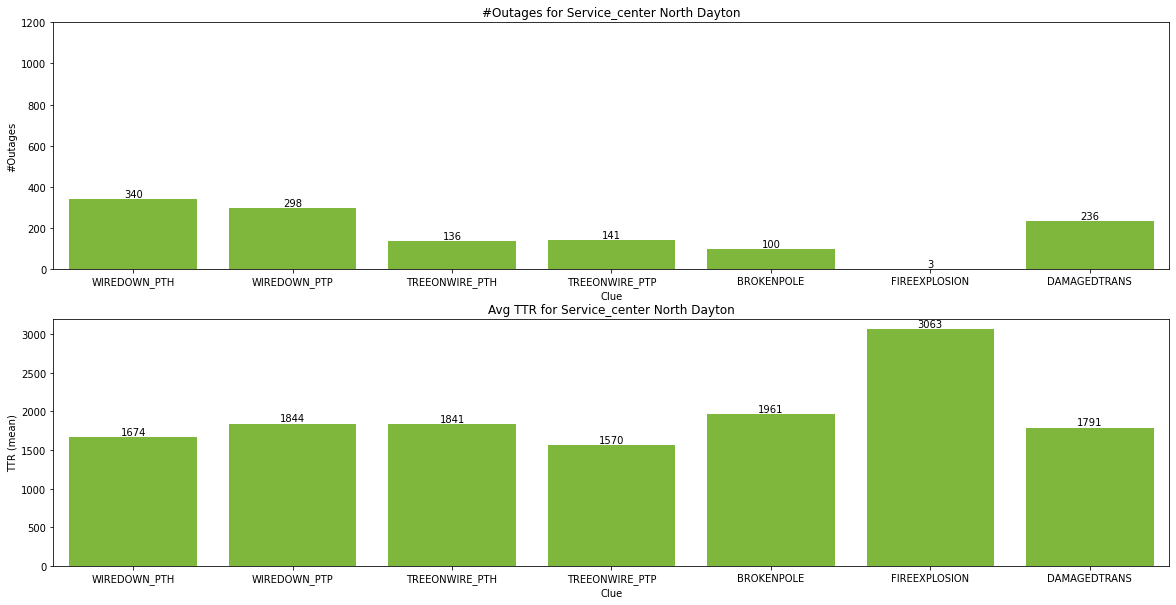

In [177]:
temp_df = pd.DataFrame()
temp_df['CLUE'] = ['WIREDOWN_PTH', 'WIREDOWN_PTP','TREEONWIRE_PTH','TREEONWIRE_PTP','BROKENPOLE','FIREEXPLOSION', 'DAMAGEDTRANS']
mean_ttr = []
count = []
for i in range(len(temp_df)):
    x = df_storm[(df_storm.Nearest_service_center == 'North Dayton') & (df[temp_df.CLUE[i]] == True)].TTR.mean()
    mean_ttr.append(x)
    x = df[(df_storm.Nearest_service_center == 'North Dayton') & (df[temp_df.CLUE[i]] == True)].TTR.count()
    count.append(x)

temp_df['Mean_ttr'] = mean_ttr
temp_df['#Outages'] = count

fig,ax =  plt.subplots(2,1,figsize=(20,10))
sns.barplot(x = temp_df['CLUE'],y = temp_df['#Outages'],palette = ['#81cb29'], ax = ax[0])
ax[0].set(xlabel = 'Clue', ylabel = '#Outages')
ax[0].set_title('#Outages for Service_center North Dayton')
ax[0].set(ylim=(0, 1200))
for p in ax[0].patches:
    x=p.get_bbox().get_points()[:,0]
    y=p.get_bbox().get_points()[1,1]
    ax[0].annotate('{:.0f}'.format(y), (x.mean(), y), 
            ha='center', va='bottom') # set the alignment of the text
ax[0].grid(False)  

sns.barplot(x = temp_df['CLUE'],y = temp_df['Mean_ttr'],palette = ['#81cb29'], ax = ax[1])
ax[1].set(xlabel = 'Clue', ylabel = 'TTR (mean)')
ax[1].set_title('Avg TTR for Service_center North Dayton')
ax[1].set(ylim=(0, 3200))
for p in ax[1].patches:
    x=p.get_bbox().get_points()[:,0]
    y=p.get_bbox().get_points()[1,1]
    ax[1].annotate('{:.0f}'.format(y), (x.mean(), y), 
            ha='center', va='bottom') # set the alignment of the text
ax[1].grid(False)    

### Sidney

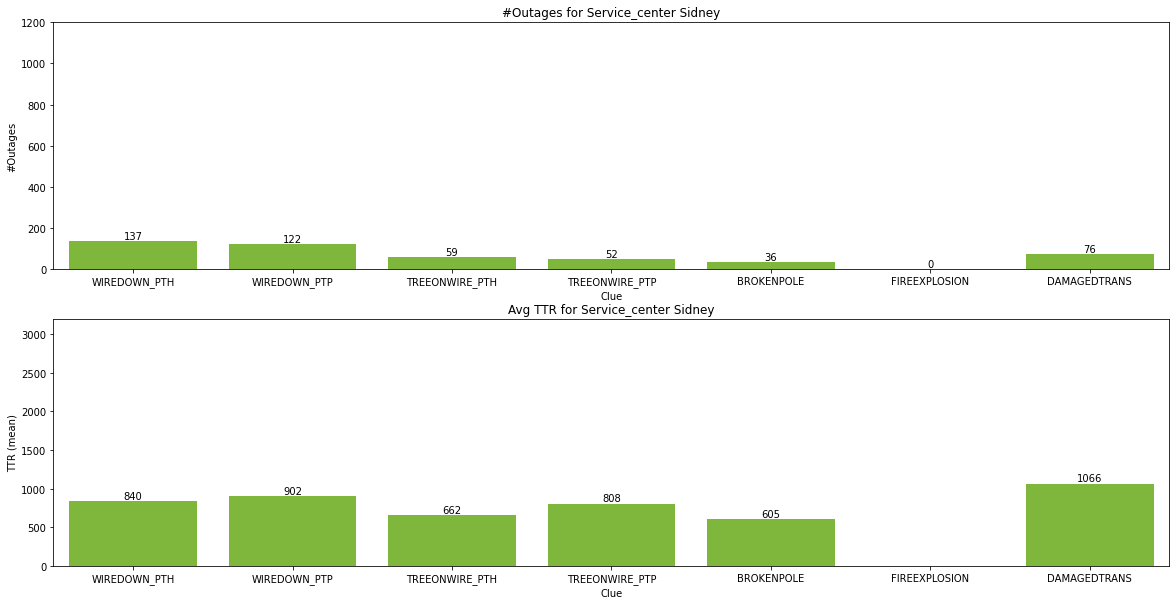

In [178]:
temp_df = pd.DataFrame()
temp_df['CLUE'] = ['WIREDOWN_PTH', 'WIREDOWN_PTP','TREEONWIRE_PTH','TREEONWIRE_PTP','BROKENPOLE','FIREEXPLOSION', 'DAMAGEDTRANS']
mean_ttr = []
count = []
for i in range(len(temp_df)):
    x = df_storm[(df_storm.Nearest_service_center == 'Sidney') & (df[temp_df.CLUE[i]] == True)].TTR.mean()
    mean_ttr.append(x)
    x = df[(df_storm.Nearest_service_center == 'Sidney') & (df[temp_df.CLUE[i]] == True)].TTR.count()
    count.append(x)

temp_df['Mean_ttr'] = mean_ttr
temp_df['#Outages'] = count

fig,ax =  plt.subplots(2,1,figsize=(20,10))
sns.barplot(x = temp_df['CLUE'],y = temp_df['#Outages'],palette = ['#81cb29'], ax = ax[0])
ax[0].set(xlabel = 'Clue', ylabel = '#Outages')
ax[0].set_title('#Outages for Service_center Sidney')
ax[0].set(ylim=(0, 1200))
for p in ax[0].patches:
    x=p.get_bbox().get_points()[:,0]
    y=p.get_bbox().get_points()[1,1]
    ax[0].annotate('{:.0f}'.format(y), (x.mean(), y), 
            ha='center', va='bottom') # set the alignment of the text
ax[0].grid(False)  

sns.barplot(x = temp_df['CLUE'],y = temp_df['Mean_ttr'],palette = ['#81cb29'], ax = ax[1])
ax[1].set(xlabel = 'Clue', ylabel = 'TTR (mean)')
ax[1].set_title('Avg TTR for Service_center Sidney')
ax[1].set(ylim=(0, 3200))
for p in ax[1].patches:
    x=p.get_bbox().get_points()[:,0]
    y=p.get_bbox().get_points()[1,1]
    ax[1].annotate('{:.0f}'.format(y), (x.mean(), y), 
            ha='center', va='bottom') # set the alignment of the text
ax[1].grid(False)  

### Greenville

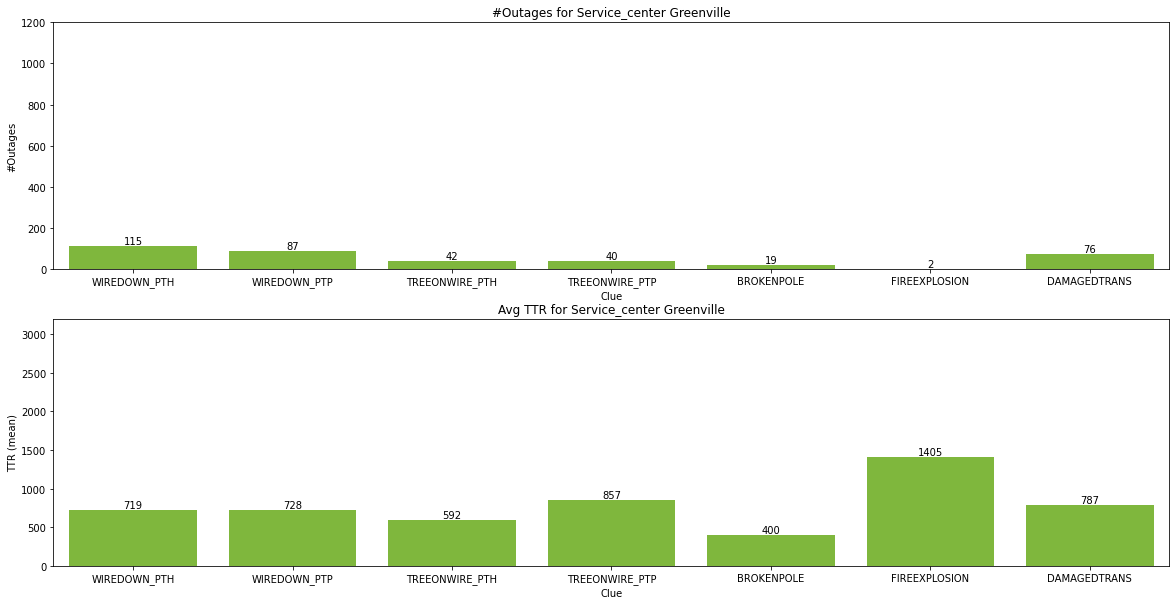

In [179]:
temp_df = pd.DataFrame()
temp_df['CLUE'] = ['WIREDOWN_PTH', 'WIREDOWN_PTP','TREEONWIRE_PTH','TREEONWIRE_PTP','BROKENPOLE','FIREEXPLOSION', 'DAMAGEDTRANS']
mean_ttr = []
count = []
for i in range(len(temp_df)):
    x = df_storm[(df_storm.Nearest_service_center == 'Greenville') & (df[temp_df.CLUE[i]] == True)].TTR.mean()
    mean_ttr.append(x)
    x = df[(df_storm.Nearest_service_center == 'Greenville') & (df[temp_df.CLUE[i]] == True)].TTR.count()
    count.append(x)

temp_df['Mean_ttr'] = mean_ttr
temp_df['#Outages'] = count

fig,ax =  plt.subplots(2,1,figsize=(20,10))
sns.barplot(x = temp_df['CLUE'],y = temp_df['#Outages'],palette = ['#81cb29'], ax = ax[0])
ax[0].set(xlabel = 'Clue', ylabel = '#Outages')
ax[0].set_title('#Outages for Service_center Greenville')
ax[0].set(ylim=(0, 1200))
for p in ax[0].patches:
    x=p.get_bbox().get_points()[:,0]
    y=p.get_bbox().get_points()[1,1]
    ax[0].annotate('{:.0f}'.format(y), (x.mean(), y), 
            ha='center', va='bottom') # set the alignment of the text
ax[0].grid(False)  

sns.barplot(x = temp_df['CLUE'],y = temp_df['Mean_ttr'],palette = ['#81cb29'], ax = ax[1])
ax[1].set(xlabel = 'Clue', ylabel = 'TTR (mean)')
ax[1].set_title('Avg TTR for Service_center Greenville')
ax[1].set(ylim=(0, 3200))
for p in ax[1].patches:
    x=p.get_bbox().get_points()[:,0]
    y=p.get_bbox().get_points()[1,1]
    ax[1].annotate('{:.0f}'.format(y), (x.mean(), y), 
            ha='center', va='bottom') # set the alignment of the text
ax[1].grid(False)  

### Eaton

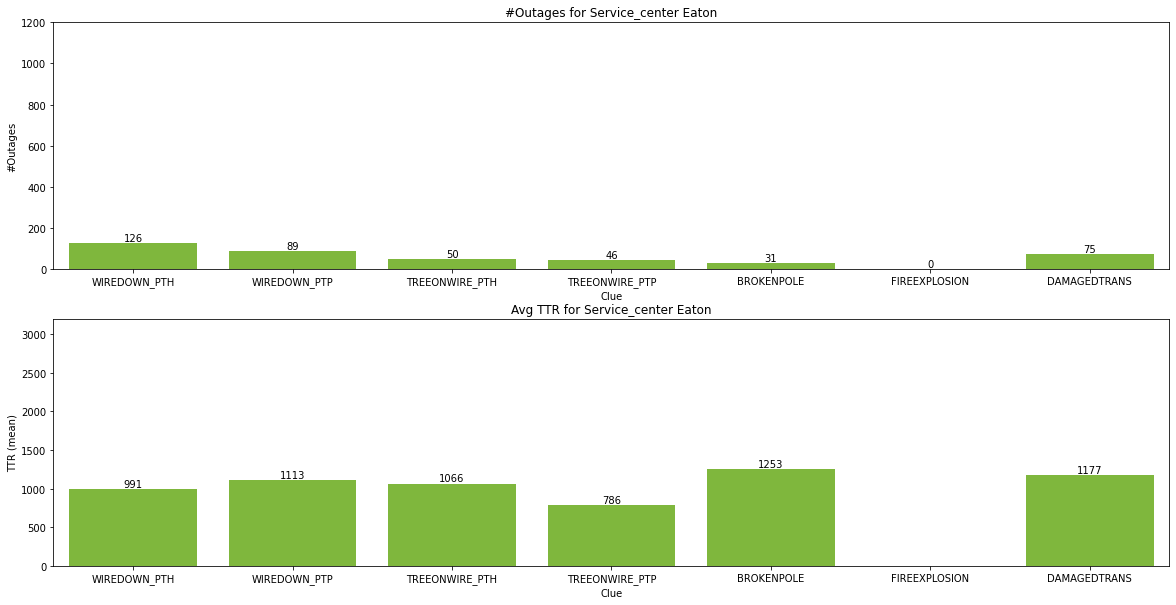

In [180]:
temp_df = pd.DataFrame()
temp_df['CLUE'] = ['WIREDOWN_PTH', 'WIREDOWN_PTP','TREEONWIRE_PTH','TREEONWIRE_PTP','BROKENPOLE','FIREEXPLOSION', 'DAMAGEDTRANS']
mean_ttr = []
count = []
for i in range(len(temp_df)):
    x = df_storm[(df_storm.Nearest_service_center == 'Eaton') & (df[temp_df.CLUE[i]] == True)].TTR.mean()
    mean_ttr.append(x)
    x = df[(df_storm.Nearest_service_center == 'Eaton') & (df[temp_df.CLUE[i]] == True)].TTR.count()
    count.append(x)

temp_df['Mean_ttr'] = mean_ttr
temp_df['#Outages'] = count

fig,ax =  plt.subplots(2,1,figsize=(20,10))

sns.barplot(x = temp_df['CLUE'],y = temp_df['#Outages'],palette = ['#81cb29'], ax = ax[0])
ax[0].set(xlabel = 'Clue', ylabel = '#Outages')
ax[0].set_title('#Outages for Service_center Eaton')
ax[0].set(ylim=(0, 1200))
for p in ax[0].patches:
    x=p.get_bbox().get_points()[:,0]
    y=p.get_bbox().get_points()[1,1]
    ax[0].annotate('{:.0f}'.format(y), (x.mean(), y), 
            ha='center', va='bottom') # set the alignment of the text
ax[0].grid(False)  

sns.barplot(x = temp_df['CLUE'],y = temp_df['Mean_ttr'],palette = ['#81cb29'], ax = ax[1])
ax[1].set(xlabel = 'Clue', ylabel = 'TTR (mean)')
ax[1].set_title('Avg TTR for Service_center Eaton')
ax[1].set(ylim=(0, 3200))
for p in ax[1].patches:
    x=p.get_bbox().get_points()[:,0]
    y=p.get_bbox().get_points()[1,1]
    ax[1].annotate('{:.0f}'.format(y), (x.mean(), y), 
            ha='center', va='bottom') # set the alignment of the text
ax[1].grid(False)  

# TTR distribution with Continuous variable

## TOTAL_CUST vs TTR

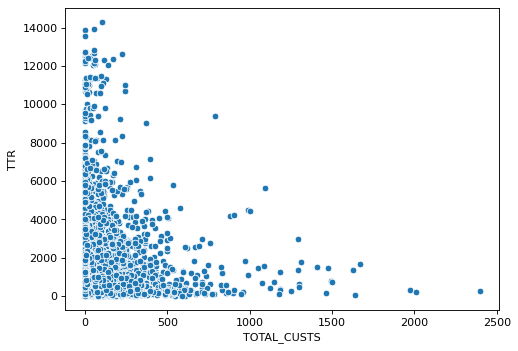

In [181]:

plt.figure(num = None,figsize=(7, 5),dpi=80,facecolor='w',edgecolor='k')

temp_df = df[['EVENT','TOTAL_CUSTS','TTR']]
temp_df = temp_df[temp_df.EVENT == 'STORM']

ax = sns.scatterplot(x = temp_df['TOTAL_CUSTS'],y = temp_df['TTR'])

## LFS_CUSTS vs TTR

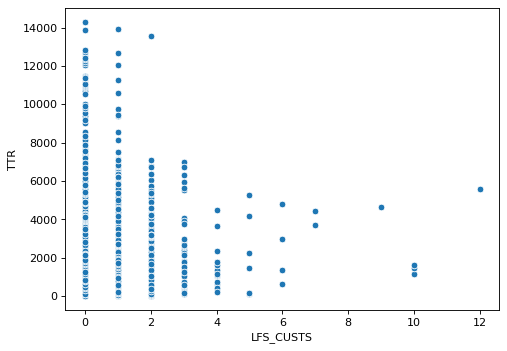

In [182]:

plt.figure(num = None,figsize=(7, 5),dpi=80,facecolor='w',edgecolor='k')

temp_df = df[['EVENT','LFS_CUSTS','TTR']]
temp_df = temp_df[temp_df.EVENT == 'STORM']

ax = sns.scatterplot(x = temp_df['LFS_CUSTS'],y = temp_df['TTR'])

## MED_CUSTS vs TTR

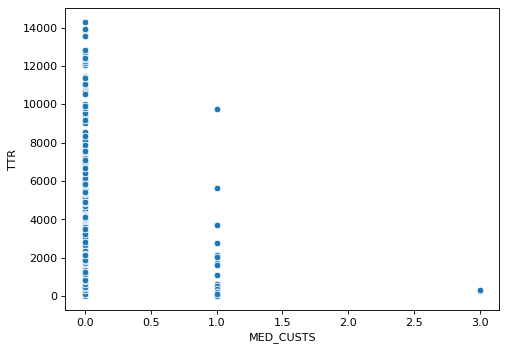

In [183]:

plt.figure(num = None,figsize=(7, 5),dpi=80,facecolor='w',edgecolor='k')

temp_df = df[['EVENT','MED_CUSTS','TTR']]
temp_df = temp_df[temp_df.EVENT == 'STORM']

ax = sns.scatterplot(x = temp_df['MED_CUSTS'],y = temp_df['TTR'])

## EMR_CUSTS vs TTR

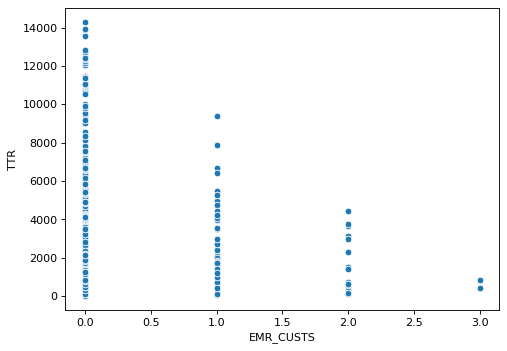

In [184]:

plt.figure(num = None,figsize=(7, 5),dpi=80,facecolor='w',edgecolor='k')

temp_df = df[['EVENT','EMR_CUSTS','TTR']]
temp_df = temp_df[temp_df.EVENT == 'STORM']

ax = sns.scatterplot(x = temp_df['EMR_CUSTS'],y = temp_df['TTR'])

## UTL_CUSTS vs TTR

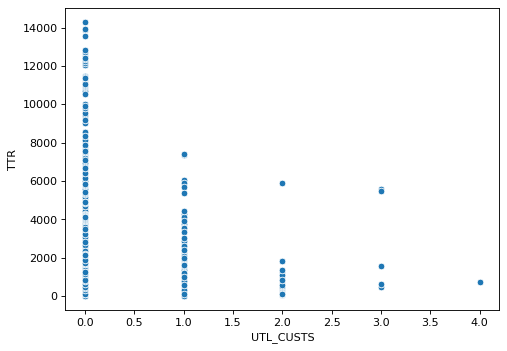

In [185]:

plt.figure(num = None,figsize=(7, 5),dpi=80,facecolor='w',edgecolor='k')

temp_df = df[['EVENT','UTL_CUSTS','TTR']]
temp_df = temp_df[temp_df.EVENT == 'STORM']

ax = sns.scatterplot(x = temp_df['UTL_CUSTS'],y = temp_df['TTR'])

## MAJ_CUSTS vs TTR

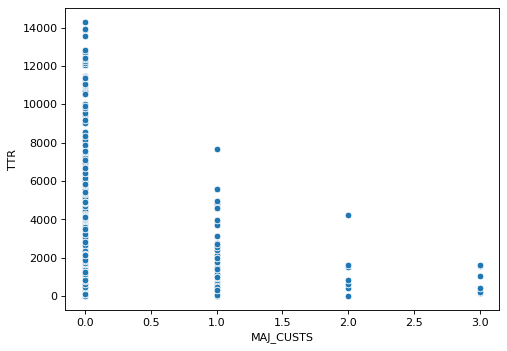

In [186]:

plt.figure(num = None,figsize=(7, 5),dpi=80,facecolor='w',edgecolor='k')

temp_df = df[['EVENT','MAJ_CUSTS','TTR']]
temp_df = temp_df[temp_df.EVENT == 'STORM']

ax = sns.scatterplot(x = temp_df['MAJ_CUSTS'],y = temp_df['TTR'])

## GOV_CUSTS vs TTR

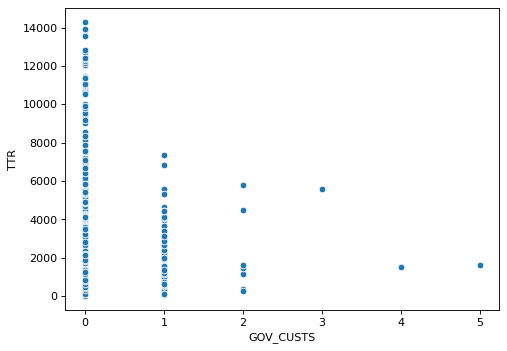

In [187]:

plt.figure(num = None,figsize=(7, 5),dpi=80,facecolor='w',edgecolor='k')

temp_df = df[['EVENT','GOV_CUSTS','TTR']]
temp_df = temp_df[temp_df.EVENT == 'STORM']

ax = sns.scatterplot(x = temp_df['GOV_CUSTS'],y = temp_df['TTR'])

## LRT_CUSTS vs TTR

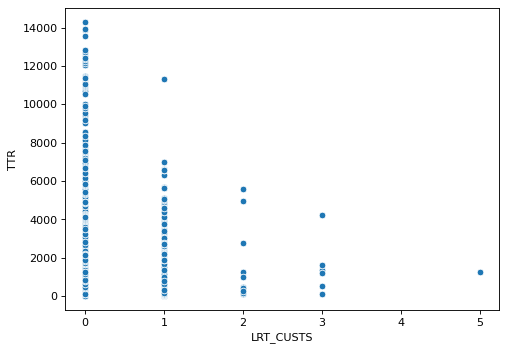

In [188]:

plt.figure(num = None,figsize=(7, 5),dpi=80,facecolor='w',edgecolor='k')

temp_df = df[['EVENT','LRT_CUSTS','TTR']]
temp_df = temp_df[temp_df.EVENT == 'STORM']

ax = sns.scatterplot(x = temp_df['LRT_CUSTS'],y = temp_df['TTR'])

## CREWSIZE vs TTR

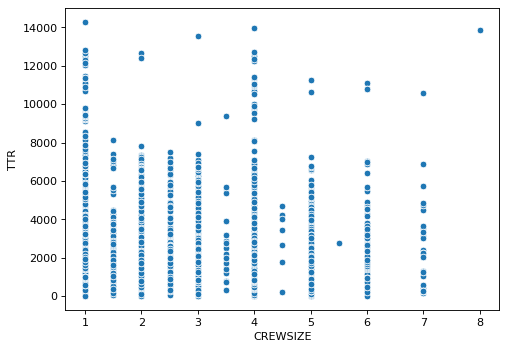

In [189]:

plt.figure(num = None,figsize=(7, 5),dpi=80,facecolor='w',edgecolor='k')

temp_df = df[['EVENT','CREWSIZE','TTR']]
temp_df = temp_df[temp_df.EVENT == 'STORM']

ax = sns.scatterplot(x = temp_df['CREWSIZE'],y = temp_df['TTR'])

## CALLCOUNT vs TTR

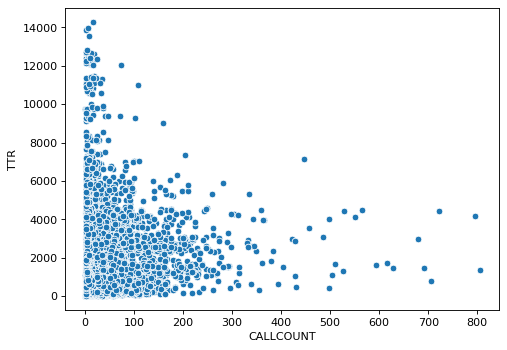

In [190]:

plt.figure(num = None,figsize=(7, 5),dpi=80,facecolor='w',edgecolor='k')

temp_df = df[['EVENT','CALLCOUNT','TTR']]
temp_df = temp_df[temp_df.EVENT == 'STORM']

ax = sns.scatterplot(x = temp_df['CALLCOUNT'],y = temp_df['TTR'])

## MAJOR vs TTR

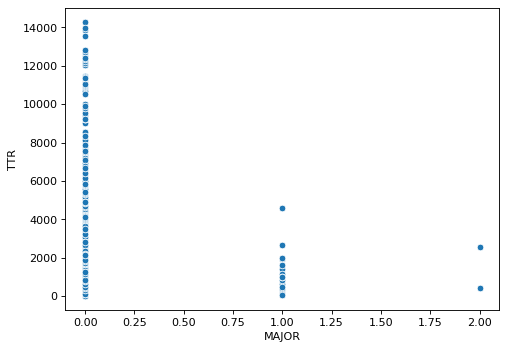

In [191]:

plt.figure(num = None,figsize=(7, 5),dpi=80,facecolor='w',edgecolor='k')

temp_df = df[['EVENT','MAJOR','TTR']]
temp_df = temp_df[temp_df.EVENT == 'STORM']

ax = sns.scatterplot(x = temp_df['MAJOR'],y = temp_df['TTR'])

## TIME_TO_ARRIVE vs TTR

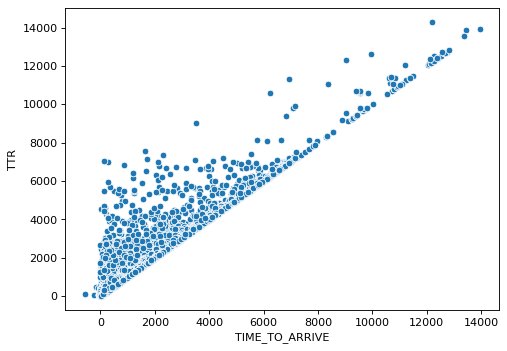

In [192]:
plt.figure(num = None,figsize=(7, 5),dpi=80,facecolor='w',edgecolor='k')

temp_df = df[['EVENT','TIME_TO_ARRIVE','TTR']]
temp_df = temp_df[temp_df.EVENT == 'STORM']

ax = sns.scatterplot(x = temp_df['TIME_TO_ARRIVE'],y = temp_df['TTR'])

## TIME_TO_RESTORE vs TTR

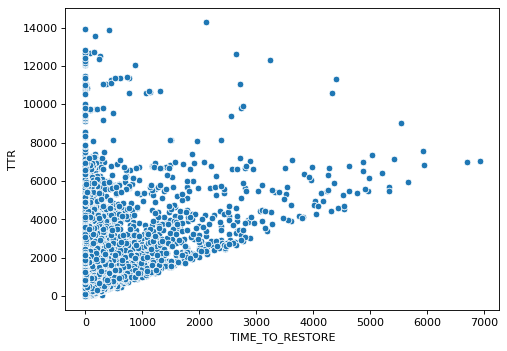

In [193]:
plt.figure(num = None,figsize=(7, 5),dpi=80,facecolor='w',edgecolor='k')

temp_df = df[['EVENT','TIME_TO_RESTORE','TTR']]
temp_df = temp_df[temp_df.EVENT == 'STORM']

ax = sns.scatterplot(x = temp_df['TIME_TO_RESTORE'],y = temp_df['TTR'])

## TIME_TO_TRAVEL vs TTR

[(0.0, 1500.0)]

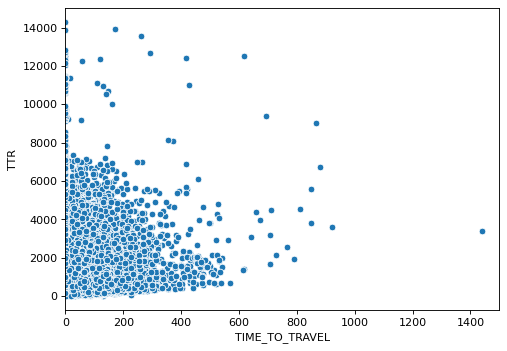

In [194]:
plt.figure(num = None,figsize=(7, 5),dpi=80,facecolor='w',edgecolor='k')

temp_df = df[['EVENT','TIME_TO_TRAVEL','TTR']]
temp_df = temp_df[temp_df.EVENT == 'STORM']

ax = sns.scatterplot(x = temp_df['TIME_TO_TRAVEL'],y = temp_df['TTR'])
ax.set(xlim=(0, 1500))

## TIME_TO_DISPATCH vs TTR

[(0.0, 24359.597999999998)]

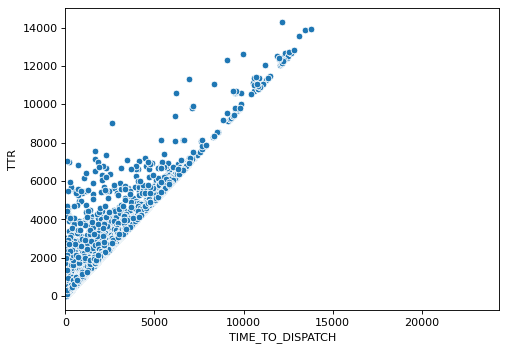

In [195]:
plt.figure(num = None,figsize=(7, 5),dpi=80,facecolor='w',edgecolor='k')

temp_df = df[['EVENT','TIME_TO_DISPATCH','TTR']]
temp_df = temp_df[temp_df.EVENT == 'STORM']

ax = sns.scatterplot(x = temp_df['TIME_TO_DISPATCH'],y = temp_df['TTR'])
ax.set(xlim=(0, None))

## Min_Distance_service_Center vs TTR

[(0.0, 79.81000399255097)]

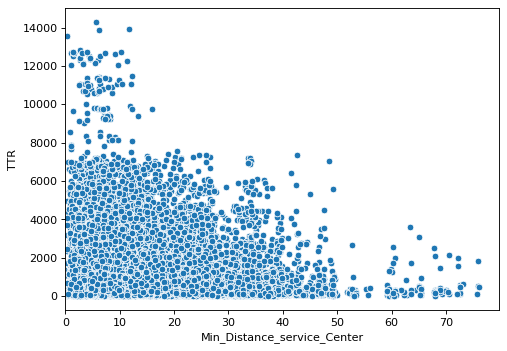

In [196]:
plt.figure(num = None,figsize=(7, 5),dpi=80,facecolor='w',edgecolor='k')

temp_df = df_storm[['Min_Distance_service_Center','TTR']]

ax = sns.scatterplot(x = temp_df['Min_Distance_service_Center'],y = temp_df['TTR'])
ax.set(xlim=(0, None))

# Deep dive into 2008 for Storm Events

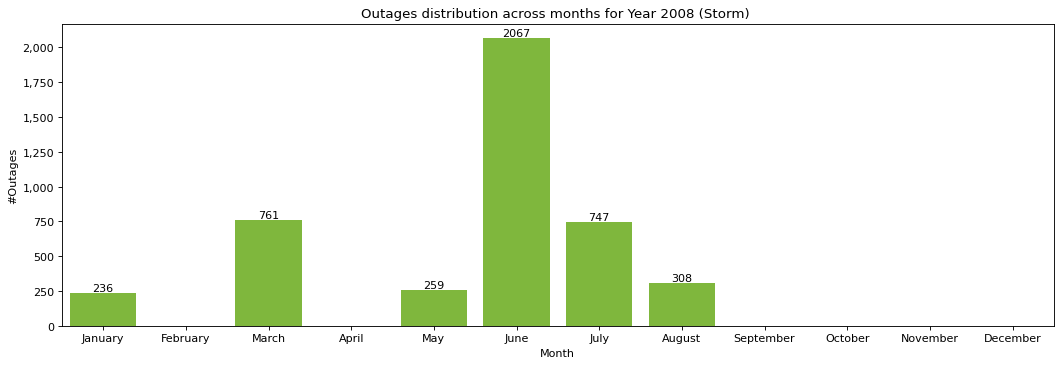

In [197]:
df_2008_storm = df[(df.TIME_OF_FIRST_CALL.dt.year > 2007) & (df.TIME_OF_FIRST_CALL.dt.year < 2009) & (df.EVENT=='STORM')]

df_2008_storm['Month'] = df_2008_storm.TIME_OF_FIRST_CALL.dt.month_name()

df_2008_storm = df_2008_storm.groupby(['Month']).size().reset_index(name='Count')

new_order = ['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October', 'November', 'December']

# Plotting Table results
plt.figure(num=None, figsize=(16, 5), dpi=80, facecolor='w', edgecolor='k')
ax = sns.barplot(x=df_2008_storm.Month, y=df_2008_storm.Count, order=new_order, palette = ['#81cb29'])
ax.set(xlabel='Month', ylabel='#Outages')
ax.get_yaxis().set_major_formatter(matplotlib.ticker.FuncFormatter(lambda x, p: format(int(x), ',')))
ax.set_title('Outages distribution across months for Year 2008 (Storm) ')
for p in ax.patches:
    x=p.get_bbox().get_points()[:,0]
    y=p.get_bbox().get_points()[1,1]
    ax.annotate('{:.0f}'.format(y), (x.mean(), y), 
            ha='center', va='bottom') # set the alignment of the text
ax.grid(False)  

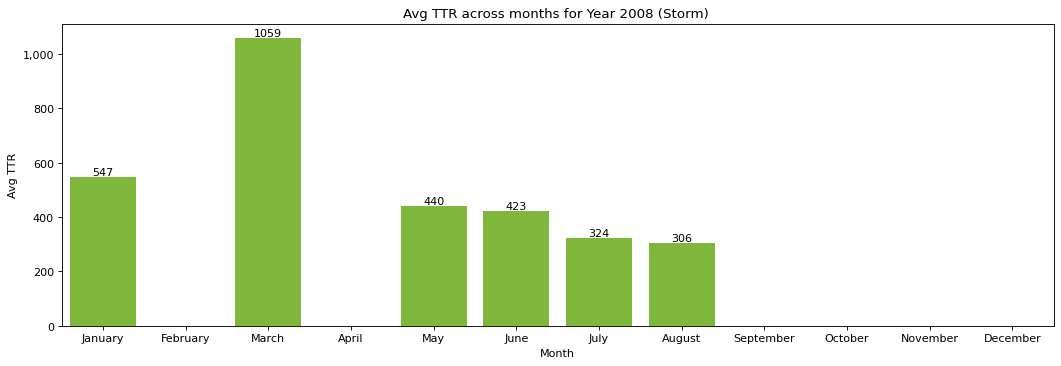

In [198]:
df_2008_storm = df[(df.TIME_OF_FIRST_CALL.dt.year > 2007) & (df.TIME_OF_FIRST_CALL.dt.year < 2009) & (df.EVENT=='STORM')]

df_2008_storm['Month'] = df_2008_storm.TIME_OF_FIRST_CALL.dt.month_name()

df_2008_storm = df_2008_storm.groupby(['Month'], as_index = False).agg({'TTR':'mean'})

new_order = ['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October', 'November', 'December']

# Plotting Table results
plt.figure(num=None, figsize=(16, 5), dpi=80, facecolor='w', edgecolor='k')
ax = sns.barplot(x=df_2008_storm.Month, y=df_2008_storm.TTR, order=new_order, color='#81cb29')
ax.set(xlabel='Month', ylabel='Avg TTR')
ax.get_yaxis().set_major_formatter(matplotlib.ticker.FuncFormatter(lambda x, p: format(int(x), ',')))
ax.set_title('Avg TTR across months for Year 2008 (Storm) ')

for p in ax.patches:
    x=p.get_bbox().get_points()[:,0]
    y=p.get_bbox().get_points()[1,1]
    ax.annotate('{:.0f}'.format(y), (x.mean(), y), 
            ha='center', va='bottom') # set the alignment of the text
ax.grid(False)  

# Deep dive into Storm Events for the year 2012

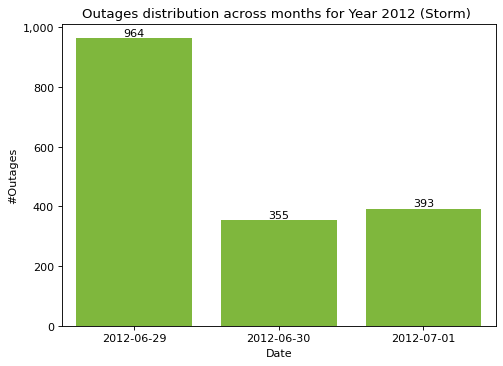

In [199]:
df_2012_storm = df[(df.TIME_OF_FIRST_CALL.dt.year > 2011) & (df.TIME_OF_FIRST_CALL.dt.year < 2013) & (df.EVENT=='STORM')]

df_2012_storm['Date'] = df_2012_storm.TIME_OF_FIRST_CALL.dt.date

df_2012_storm = df_2012_storm.groupby(['Date']).size().reset_index(name='Count')

# Plotting Table results
plt.figure(num=None, figsize=(7, 5), dpi=80, facecolor='w', edgecolor='k')
ax = sns.barplot(x=df_2012_storm.Date, y=df_2012_storm.Count,color='#81cb29')
ax.set(xlabel='Date', ylabel='#Outages')
ax.get_yaxis().set_major_formatter(matplotlib.ticker.FuncFormatter(lambda x, p: format(int(x), ',')))
ax.set_title('Outages distribution across months for Year 2012 (Storm) ')

for p in ax.patches:
    x=p.get_bbox().get_points()[:,0]
    y=p.get_bbox().get_points()[1,1]
    ax.annotate('{:.0f}'.format(y), (x.mean(), y), 
            ha='center', va='bottom') # set the alignment of the text
ax.grid(False)  

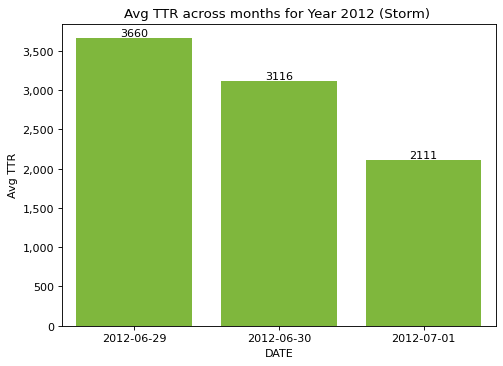

In [200]:
df_2012_storm = df[(df.TIME_OF_FIRST_CALL.dt.year > 2011) & (df.TIME_OF_FIRST_CALL.dt.year < 2013) & (df.EVENT=='STORM')]
df_2012_storm['DATE'] = df_2012_storm.TIME_OF_FIRST_CALL.dt.date

df_2012_storm = df_2012_storm.groupby(['DATE'], as_index = False).agg({'TTR':'mean'})

# Plotting Table results
plt.figure(num=None, figsize=(7, 5), dpi=80, facecolor='w', edgecolor='k')
ax = sns.barplot(x=df_2012_storm.DATE, y=df_2012_storm.TTR, color='#81cb29')
ax.set(xlabel='DATE', ylabel='Avg TTR')
ax.get_yaxis().set_major_formatter(matplotlib.ticker.FuncFormatter(lambda x, p: format(int(x), ',')))
ax.set_title('Avg TTR across months for Year 2012 (Storm) ')

for p in ax.patches:
    x=p.get_bbox().get_points()[:,0]
    y=p.get_bbox().get_points()[1,1]
    ax.annotate('{:.0f}'.format(y), (x.mean(), y), 
            ha='center', va='bottom') # set the alignment of the text
ax.grid(False)  

# Deep dive into Storm Events for the year 2019

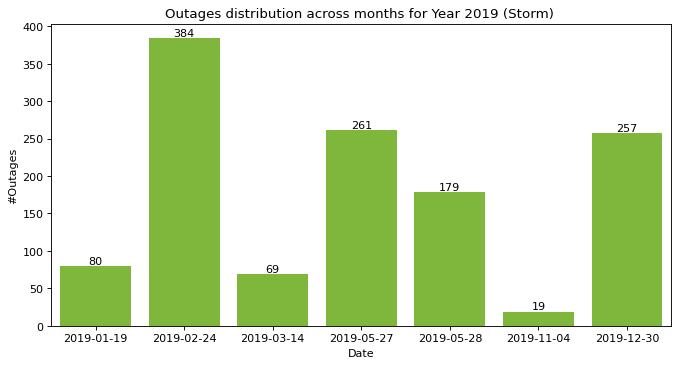

In [201]:
df_2019_storm = df[(df.TIME_OF_FIRST_CALL.dt.year == 2019)& (df.EVENT=='STORM')]

df_2019_storm['Date'] = df_2019_storm.TIME_OF_FIRST_CALL.dt.date

df_2019_storm = df_2019_storm.groupby(['Date']).size().reset_index(name='Count')

# Plotting Table results
plt.figure(num=None, figsize=(10, 5), dpi=80, facecolor='w', edgecolor='k')
ax = sns.barplot(x=df_2019_storm.Date, y=df_2019_storm.Count,color='#81cb29')
ax.set(xlabel='Date', ylabel='#Outages')
ax.get_yaxis().set_major_formatter(matplotlib.ticker.FuncFormatter(lambda x, p: format(int(x), ',')))
ax.set_title('Outages distribution across months for Year 2019 (Storm) ')

for p in ax.patches:
    x=p.get_bbox().get_points()[:,0]
    y=p.get_bbox().get_points()[1,1]
    ax.annotate('{:.0f}'.format(y), (x.mean(), y), 
            ha='center', va='bottom') # set the alignment of the text
ax.grid(False)  

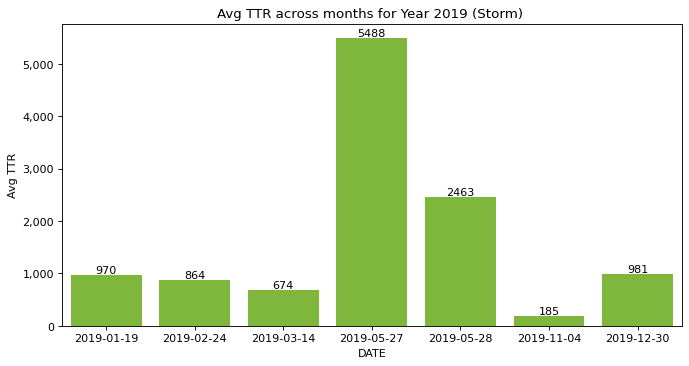

In [202]:
df_2019_storm = df[(df.TIME_OF_FIRST_CALL.dt.year == 2019)& (df.EVENT=='STORM')]
df_2019_storm['DATE'] = df_2019_storm.TIME_OF_FIRST_CALL.dt.date

df_2019_storm = df_2019_storm.groupby(['DATE'], as_index = False).agg({'TTR':'mean'})

# Plotting Table results
plt.figure(num=None, figsize=(10, 5), dpi=80, facecolor='w', edgecolor='k')
ax = sns.barplot(x=df_2019_storm.DATE, y=df_2019_storm.TTR, color='#81cb29')
ax.set(xlabel='DATE', ylabel='Avg TTR')
ax.get_yaxis().set_major_formatter(matplotlib.ticker.FuncFormatter(lambda x, p: format(int(x), ',')))
ax.set_title('Avg TTR across months for Year 2019 (Storm) ')

for p in ax.patches:
    x=p.get_bbox().get_points()[:,0]
    y=p.get_bbox().get_points()[1,1]
    ax.annotate('{:.0f}'.format(y), (x.mean(), y), 
            ha='center', va='bottom') # set the alignment of the text
ax.grid(False)  

# Deep dive into Storm Events for the year 2018

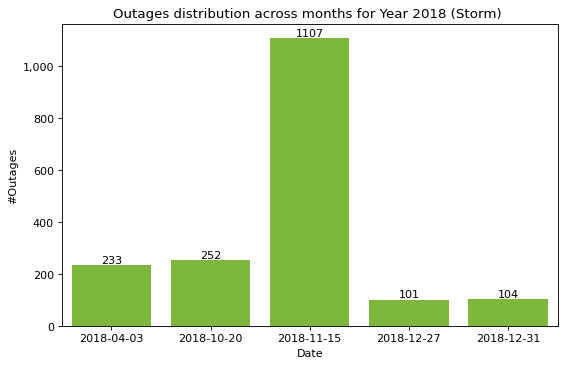

In [203]:
df_2018_storm = df[(df.TIME_OF_FIRST_CALL.dt.year == 2018)& (df.EVENT=='STORM')]

df_2018_storm['Date'] = df_2018_storm.TIME_OF_FIRST_CALL.dt.date

df_2018_storm = df_2018_storm.groupby(['Date']).size().reset_index(name='Count')

# Plotting Table results
plt.figure(num=None, figsize=(8, 5), dpi=80, facecolor='w', edgecolor='k')
ax = sns.barplot(x=df_2018_storm.Date, y=df_2018_storm.Count,color='#81cb29')
ax.set(xlabel='Date', ylabel='#Outages')
ax.get_yaxis().set_major_formatter(matplotlib.ticker.FuncFormatter(lambda x, p: format(int(x), ',')))
ax.set_title('Outages distribution across months for Year 2018 (Storm) ')

for p in ax.patches:
    x=p.get_bbox().get_points()[:,0]
    y=p.get_bbox().get_points()[1,1]
    ax.annotate('{:.0f}'.format(y), (x.mean(), y), 
            ha='center', va='bottom') # set the alignment of the text
ax.grid(False)  

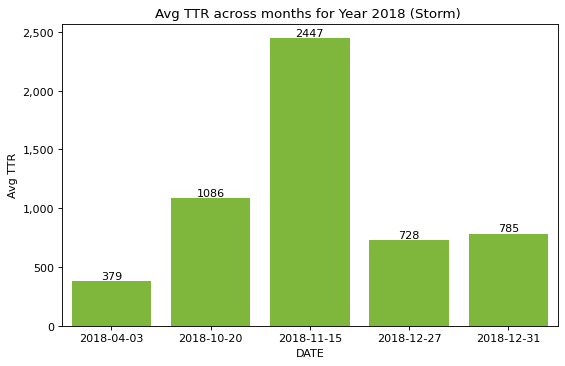

In [204]:
df_2018_storm = df[(df.TIME_OF_FIRST_CALL.dt.year == 2018)& (df.EVENT=='STORM')]
df_2018_storm['DATE'] = df_2018_storm.TIME_OF_FIRST_CALL.dt.date

df_2018_storm = df_2018_storm.groupby(['DATE'], as_index = False).agg({'TTR':'mean'})

# Plotting Table results
plt.figure(num=None, figsize=(8, 5), dpi=80, facecolor='w', edgecolor='k')
ax = sns.barplot(x=df_2018_storm.DATE, y=df_2018_storm.TTR, color='#81cb29')
ax.set(xlabel='DATE', ylabel='Avg TTR')
ax.get_yaxis().set_major_formatter(matplotlib.ticker.FuncFormatter(lambda x, p: format(int(x), ',')))
ax.set_title('Avg TTR across months for Year 2018 (Storm) ')

for p in ax.patches:
    x=p.get_bbox().get_points()[:,0]
    y=p.get_bbox().get_points()[1,1]
    ax.annotate('{:.0f}'.format(y), (x.mean(), y), 
            ha='center', va='bottom') # set the alignment of the text
ax.grid(False)  

# Deep dive into Storm Events for the year 2011

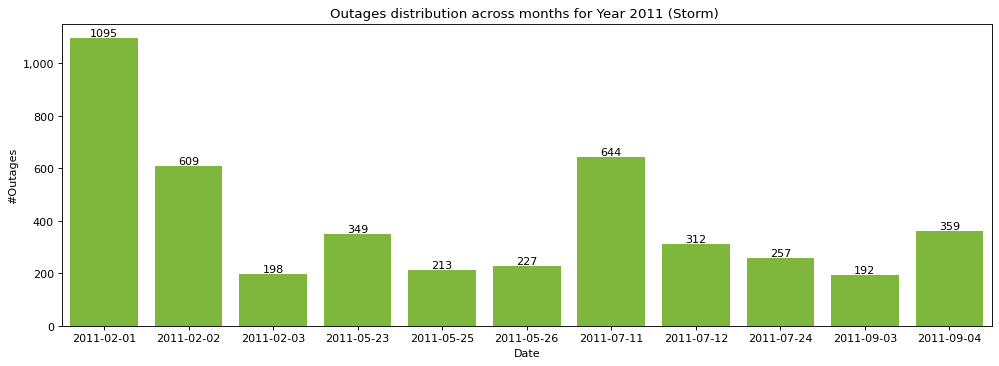

In [205]:
df_2011_storm = df[(df.TIME_OF_FIRST_CALL.dt.year == 2011)& (df.EVENT=='STORM')]

df_2011_storm['Date'] = df_2011_storm.TIME_OF_FIRST_CALL.dt.date

df_2011_storm = df_2011_storm.groupby(['Date']).size().reset_index(name='Count')

# Plotting Table results
plt.figure(num=None, figsize=(15, 5), dpi=80, facecolor='w', edgecolor='k')
ax = sns.barplot(x=df_2011_storm.Date, y=df_2011_storm.Count,color='#81cb29')
ax.set(xlabel='Date', ylabel='#Outages')
ax.get_yaxis().set_major_formatter(matplotlib.ticker.FuncFormatter(lambda x, p: format(int(x), ',')))
ax.set_title('Outages distribution across months for Year 2011 (Storm) ')

for p in ax.patches:
    x=p.get_bbox().get_points()[:,0]
    y=p.get_bbox().get_points()[1,1]
    ax.annotate('{:.0f}'.format(y), (x.mean(), y), 
            ha='center', va='bottom') # set the alignment of the text
ax.grid(False)  

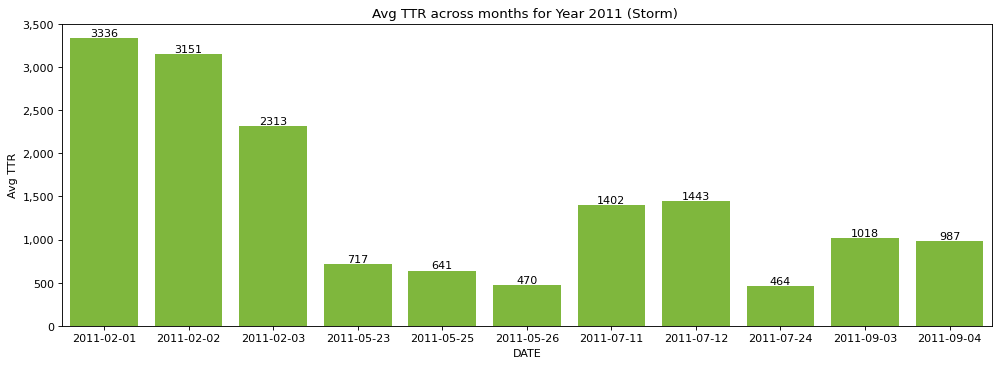

In [206]:
df_2011_storm = df[(df.TIME_OF_FIRST_CALL.dt.year == 2011)& (df.EVENT=='STORM')]
df_2011_storm['DATE'] = df_2011_storm.TIME_OF_FIRST_CALL.dt.date

df_2011_storm = df_2011_storm.groupby(['DATE'], as_index = False).agg({'TTR':'mean'})

# Plotting Table results
plt.figure(num=None, figsize=(15, 5), dpi=80, facecolor='w', edgecolor='k')
ax = sns.barplot(x=df_2011_storm.DATE, y=df_2011_storm.TTR, color='#81cb29')
ax.set(xlabel='DATE', ylabel='Avg TTR')
ax.get_yaxis().set_major_formatter(matplotlib.ticker.FuncFormatter(lambda x, p: format(int(x), ',')))
ax.set_title('Avg TTR across months for Year 2011 (Storm) ')

for p in ax.patches:
    x=p.get_bbox().get_points()[:,0]
    y=p.get_bbox().get_points()[1,1]
    ax.annotate('{:.0f}'.format(y), (x.mean(), y), 
            ha='center', va='bottom') # set the alignment of the text
ax.grid(False)  

In [207]:
temp_df = df_storm[['STORM_TYPE','TIME_OF_FIRST_CALL','TTR','FROMDATE']]
temp_df['DATE'] = pd.to_datetime(temp_df['TIME_OF_FIRST_CALL'], infer_datetime_format = True, errors = 'coerce').dt.date
temp_df = temp_df.groupby(['STORM_TYPE','FROMDATE'],as_index = False).agg({'TTR':['mean','count']})
temp_df.columns = ['STORM_TYPE','FROMDATE','Avg_TTR','#Outages']

KeyError: "['STORM_TYPE', 'FROMDATE'] not in index"

## Deep dive on Storm type

### Top 10 Storm type from 2002 - 2019 having high TTR

In [ ]:
plt.figure(num = None,figsize=(16, 5),dpi=80,facecolor='w',edgecolor='k')
temp_df_1 = temp_df.sort_values(['Avg_TTR'],ascending = False)[:10]
ax = sns.barplot(x = temp_df_1['FROMDATE'],y = temp_df_1['Avg_TTR'],palette = ['#81cb29'])
ax.set(xlabel = 'FROMDATE', ylabel = 'Total Time of Restoration')
ax.set_xticklabels(labels =  temp_df_1['STORM_TYPE'].str[:10] + temp_df_1['FROMDATE'].astype(str).str[:10], rotation=30)
ax.set_title('Top 10 STORM_TYPE by Avg TTR')

for p in ax.patches:
    x=p.get_bbox().get_points()[:,0]
    y=p.get_bbox().get_points()[1,1]
    ax.annotate('{:.0f}'.format(y), (x.mean(), y), 
            ha='center', va='bottom') # set the alignment of the text
ax.grid(False)  
temp_df_1[['FROMDATE','STORM_TYPE','Avg_TTR','#Outages']]

### Top 10 Storm type from 2002 - 2019 having low TTR

In [ ]:
plt.figure(num = None,figsize=(16, 5),dpi=80,facecolor='w',edgecolor='k')
temp_df_1 = temp_df.sort_values(['Avg_TTR'],ascending = False)[-10:]
ax = sns.barplot(x = temp_df_1['FROMDATE'],y = temp_df_1['Avg_TTR'],palette = ['#81cb29'])
ax.set(xlabel = 'FROMDATE', ylabel = 'Total Time of Restoration (mins)')
ax.set_xticklabels(labels =  temp_df_1['STORM_TYPE'].str[:10] + temp_df_1['FROMDATE'].astype(str).str[:10], rotation=30)
ax.set_title('Bottom 10 STORM_TYPE by Avg TTR')
ax.set(ylim=(0, 6500))

for p in ax.patches:
    x=p.get_bbox().get_points()[:,0]
    y=p.get_bbox().get_points()[1,1]
    ax.annotate('{:.0f}'.format(y), (x.mean(), y), 
            ha='center', va='bottom') # set the alignment of the text
ax.grid(False)  
temp_df_1[['FROMDATE','STORM_TYPE','Avg_TTR','#Outages']]

In [ ]:
temp_df = df_storm[['STORM_TYPE','TIME_OF_FIRST_CALL','TTR','FROMDATE']]

import regex as re
# temp_df['STORM_TYPE'] =  temp_df['STORM_TYPE'].apply(lambda x: re.sub(r'/Hurricane/','Hurricane', str(x)))
for i in range(0,len(temp_df['STORM_TYPE'])):
    match = re.search(r'\bHurricane\b', str(temp_df['STORM_TYPE'][i]))
    if match:
        temp_df['STORM_TYPE'][i] = ' Hurricane'
    else:
        match = re.search(r'thunderstorm', str(temp_df['STORM_TYPE'][i]), re.IGNORECASE)
        if match:
            temp_df['STORM_TYPE'][i] = ' Thunderstorm'
        else:
            match = re.search(r'\bTornado\b', str(temp_df['STORM_TYPE'][i]))
            if match:
                temp_df['STORM_TYPE'][i] = ' Tornado'
            else:
                match = re.search(r'ice', str(temp_df['STORM_TYPE'][i]), re.IGNORECASE)
                if match:
                    temp_df['STORM_TYPE'][i] = ' Ice'
                else:
                    match = re.search(r'wind', str(temp_df['STORM_TYPE'][i]), re.IGNORECASE)
                    if match:
                        temp_df['STORM_TYPE'][i] = ' Wind'
                    else:
                        match = re.search(r'lightning', str(temp_df['STORM_TYPE'][i]), re.IGNORECASE)
                        if match:
                            temp_df['STORM_TYPE'][i] = ' Lightning'
                        else:
                            match = re.search(r'snow', str(temp_df['STORM_TYPE'][i]), re.IGNORECASE)
                            if match:
                                temp_df['STORM_TYPE'][i] = ' Snow'
                            else:
                                temp_df['STORM_TYPE'][i] = 'others'

### Avg TTR and outages for different Storm Type

In [ ]:
plt.figure(num = None,figsize=(16, 5),dpi=80,facecolor='w',edgecolor='k')

temp_df_1 = temp_df.groupby(['STORM_TYPE'],as_index = False).agg({'TTR':['mean','count']})
temp_df_1.columns = ['STORM_TYPE','Avg_TTR','#Outages']

ax = sns.barplot(x = temp_df_1['STORM_TYPE'],y = temp_df_1['Avg_TTR'],palette = ['#81cb29'])
ax.set(xlabel = 'STORM_TYPE', ylabel = 'Total Time of Restoration')
ax.set_xticklabels(labels =  temp_df_1['STORM_TYPE'], rotation=30)
ax.set_title('Avg TTR across diff STORM_TYPE')

for p in ax.patches:
    x=p.get_bbox().get_points()[:,0]
    y=p.get_bbox().get_points()[1,1]
    ax.annotate('{:.0f}'.format(y), (x.mean(), y), 
            ha='center', va='bottom') # set the alignment of the text
ax.grid(False)  

In [ ]:
plt.figure(num = None,figsize=(16, 5),dpi=80,facecolor='w',edgecolor='k')

ax = sns.barplot(x = temp_df_1['STORM_TYPE'],y = temp_df_1['#Outages'],palette = ['#81cb29'])
ax.set(xlabel = 'STORM_TYPE', ylabel = '#Outages')
ax.set_xticklabels(labels =  temp_df_1['STORM_TYPE'], rotation=30)
ax.set_title('#Outages across diff STORM_TYPE')

for p in ax.patches:
    x=p.get_bbox().get_points()[:,0]
    y=p.get_bbox().get_points()[1,1]
    ax.annotate('{:.0f}'.format(y), (x.mean(), y), 
            ha='center', va='bottom') # set the alignment of the text
ax.grid(False)  

In [ ]:
df_storm.head()

## Disrtribution of TTR and #Outages across Day and Hour

In [ ]:
# Filtering for Storm Events
df_ttr_hm = pd.DataFrame()
df_ttr_hm = df_storm[:]
df_ttr_hm["DAY"] = df_ttr_hm.TIME_OF_FIRST_CALL.dt.day_name()
df_ttr_hm["HOUR"] = df_ttr_hm.TIME_OF_FIRST_CALL.dt.hour
df_ttr_hm = df_ttr_hm.groupby(['DAY','HOUR'])['TTR'].mean().reset_index(name='AVG TTR')
df_ttr_hm = df_ttr_hm.pivot("HOUR", "DAY", "AVG TTR")
order_week = ['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday']
df_ttr_hm = df_ttr_hm.reindex(columns=order_week)

fig,ax =  plt.subplots(1,2,figsize=(20,10))

#plt.figure(num=None, figsize=(14, 10), dpi=80, facecolor='w', edgecolor='k')
sns.heatmap(df_ttr_hm, linewidths=0.4, cmap="YlOrRd", cbar_kws={'label': 'Avg. TTR'},ax = ax[0])
ax[0].invert_yaxis()
ax[0].set_title('Average TTR across Day of Week and Time of Day')

# Filtering for Storm Events
df_ttr_hm = pd.DataFrame()
df_ttr_hm = df_storm[:]
df_ttr_hm["DAY"] = df_ttr_hm.TIME_OF_FIRST_CALL.dt.day_name()
df_ttr_hm["HOUR"] = df_ttr_hm.TIME_OF_FIRST_CALL.dt.hour
df_ttr_hm = df_ttr_hm.groupby(['DAY','HOUR']).size().reset_index(name='Event')
df_ttr_hm = df_ttr_hm.pivot("HOUR", "DAY", "Event")
order_week = ['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday']
df_ttr_hm = df_ttr_hm.reindex(columns=order_week)

sns.heatmap(df_ttr_hm, linewidths=0.4, cmap="YlOrRd", cbar_kws={'label': '# events'}, ax = ax[1])
ax[1].invert_yaxis()
ax[1].set_title('#Outage Events across Day of Week and Time of Day')

### Removing 2008 data

In [ ]:
# Filtering for Storm Events
df_ttr_hm = pd.DataFrame()
df_ttr_hm = df_storm[df_storm.TIME_OF_FIRST_CALL.dt.year != 2008]
df_ttr_hm["DAY"] = df_ttr_hm.TIME_OF_FIRST_CALL.dt.day_name()
df_ttr_hm["HOUR"] = df_ttr_hm.TIME_OF_FIRST_CALL.dt.hour
df_ttr_hm = df_ttr_hm.groupby(['DAY','HOUR'])['TTR'].mean().reset_index(name='AVG TTR')
df_ttr_hm = df_ttr_hm.pivot("HOUR", "DAY", "AVG TTR")
order_week = ['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday']
df_ttr_hm = df_ttr_hm.reindex(columns=order_week)

fig,ax =  plt.subplots(1,2,figsize=(20,10))

#plt.figure(num=None, figsize=(14, 10), dpi=80, facecolor='w', edgecolor='k')
sns.heatmap(df_ttr_hm, linewidths=0.4, cmap="YlOrRd", cbar_kws={'label': 'Avg. TTR'},ax = ax[0])
ax[0].invert_yaxis()
ax[0].set_title('Average TTR across Day of Week and Time of Day')

# Filtering for Storm Events
df_ttr_hm = pd.DataFrame()
df_ttr_hm = df_storm[df_storm.TIME_OF_FIRST_CALL.dt.year != 2008]
df_ttr_hm["DAY"] = df_ttr_hm.TIME_OF_FIRST_CALL.dt.day_name()
df_ttr_hm["HOUR"] = df_ttr_hm.TIME_OF_FIRST_CALL.dt.hour
df_ttr_hm = df_ttr_hm.groupby(['DAY','HOUR']).size().reset_index(name='Event')
df_ttr_hm = df_ttr_hm.pivot("HOUR", "DAY", "Event")
order_week = ['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday']
df_ttr_hm = df_ttr_hm.reindex(columns=order_week)

sns.heatmap(df_ttr_hm, linewidths=0.4, cmap="YlOrRd", cbar_kws={'label': '# events'}, ax = ax[1])
ax[1].invert_yaxis()
ax[1].set_title('#Outage Events across Day of Week and Time of Day')

### Blue sky

In [ ]:
# Filtering for Storm Events
df_ttr_hm = pd.DataFrame()
df_ttr_hm = df[df.EVENT == 'BLUE SKY']
df_ttr_hm["DAY"] = df_ttr_hm.TIME_OF_FIRST_CALL.dt.day_name()
df_ttr_hm["HOUR"] = df_ttr_hm.TIME_OF_FIRST_CALL.dt.hour
df_ttr_hm = df_ttr_hm.groupby(['DAY','HOUR'])['TTR'].mean().reset_index(name='AVG TTR')
df_ttr_hm = df_ttr_hm.pivot("HOUR", "DAY", "AVG TTR")
order_week = ['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday']
df_ttr_hm = df_ttr_hm.reindex(columns=order_week)

fig,ax =  plt.subplots(1,2,figsize=(20,10))

#plt.figure(num=None, figsize=(14, 10), dpi=80, facecolor='w', edgecolor='k')
sns.heatmap(df_ttr_hm, linewidths=0.4, cmap="YlOrRd", cbar_kws={'label': 'Avg. TTR'},ax = ax[0])
ax[0].invert_yaxis()
ax[0].set_title('Average TTR across Day of Week and Time of Day')

# Filtering for Storm Events
df_ttr_hm = pd.DataFrame()
df_ttr_hm = df[df.EVENT == 'BLUE SKY']
df_ttr_hm["DAY"] = df_ttr_hm.TIME_OF_FIRST_CALL.dt.day_name()
df_ttr_hm["HOUR"] = df_ttr_hm.TIME_OF_FIRST_CALL.dt.hour
df_ttr_hm = df_ttr_hm.groupby(['DAY','HOUR']).size().reset_index(name='Event')
df_ttr_hm = df_ttr_hm.pivot("HOUR", "DAY", "Event")
order_week = ['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday']
df_ttr_hm = df_ttr_hm.reindex(columns=order_week)

sns.heatmap(df_ttr_hm, linewidths=0.4, cmap="YlOrRd", cbar_kws={'label': '# events'}, ax = ax[1])
ax[1].invert_yaxis()
ax[1].set_title('#Outage Events across Day of Week and Time of Day')

### Deep dive

In [ ]:
x = df_storm[(df_storm.weekday == 'Sunday') & (df_storm.TIME_OF_FIRST_CALL.dt.hour > 12) & (df_storm.TIME_OF_FIRST_CALL.dt.hour < 19)]
x.groupby(['DATE','STORM_TYPE']).agg({'TTR':['mean','count']})

# Correlation matrix

In [ ]:
corrMatrix = df_storm[['PHASE_A_CUSTS', 'PHASE_B_CUSTS', 'PHASE_C_CUSTS', 'PHASE_T_CUSTS', 'PHASE_A_CALLS', 'PHASE_B_CALLS', 'PHASE_C_CALLS', 'PHASE_T_CALLS',
                        'TOTAL_CUSTS','LFS_CUSTS', 'MED_CUSTS', 'EMR_CUSTS', 'UTL_CUSTS', 'Outages_in_last_1hr', 'Outages_in_last_2hr', 'Outages_in_last_3hr', 
                       'Outages_in_last_4hr', 'Outages_in_last_5hr', 'Outages_in_last_6hr', 'Outages_in_last_7hr', 'Outages_in_last_8hr',
                       'Outages_in_last_9hr', 'Outages_in_last_10hr','NONRES_CUSTS', 'NONRES_CALLS','CREWSIZE',
                       'MAJ_CUSTS', 'GOV_CUSTS', 'LRT_CUSTS', 'CREWSIZE', 'TTR', 'TIME_TO_DISPATCH', 'TIME_TO_RESTORE', 'TIME_TO_ARRIVE', 'TIME_TO_TRAVEL',
                       'Hour_Sin', 'Hour_Cos', 'RANK_SUBSEQUENT_OTG','CALLCOUNT', 'TORD_False', 'TORD_True']].corr()
plt.figure(num = None,figsize=(12, 8),dpi=80,facecolor='w',edgecolor='k')
ax = sns.heatmap(corrMatrix,center=0)
ax.set_title('Continous variables')